National Research University "Higher School of Economics"

Master of Data Science Online Programme

Master's Thesis

Topic: Electricity Spot Prices Forecasting Using Stochastic Volatility Models

Computations Notebook

Student: Andrei Batyrov (Fall2022)

Date: 09-May-2024

##### <a id="toc"></a>Table of Contents

1. [Description](#description)

2. [SV Baseline Model](#sv-base)

    2.1. [Price Data](#load-price-data)

    2.2. [Test For Stationarity](#price-data-adf)

    2.3. [Modeling](#model-sv-base)

    2.4. [Goodness-of-fit](#eval-sv-base)

3. [SV Exogenous Model](#sv-x)

    3.1. [Temperature Data](#load-temp-data)

    3.2. [Weekday](#load-weekday-data)

    3.3. [Autoregressive Component](#ar-1)

    3.4. [Modeling](#model-sv-x)

    3.5. [Goodness-of-fit](#eval-sv-x)

4. [Cross-validation](#cross-val)

    4.2. [Strategy](#cross-val-sv-strat)
    
    4.2. [SV Baseline](#cross-val-sv-base)

    4.3. [SV X](#cross-val-sv-x)

    4.4. [Model Comparison](#cross-val-comparison)

5. [Forecasting](#forecast)

6. [References](#refs)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.cluster import KMeans
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller, pacf
from scipy.stats import norm, probplot, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from stan_model import StanModel
# This is needed to solve the problem with SSL certificates from www.atsenergo.ru
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

---
##### <a id="description"></a>1. Description

There are several approaches to modeling and forecasting time series as applied to prices of services, commodities, and derivative instruments. One of the approaches is to model the price as a heteroscedastic process with changing volatility (variance of price) over time.

In our scenario we will consider a typical Stochastic Volatility model that treats the volatility as a latent stochastic process in discrete time (Kim, Shephard, and Chib 1998) Kim, Sangjoon, Neil Shephard, and Siddhartha Chib. 1998. "Stochastic Volatility: Likelihood Inference and Comparison with ARCH Models." Review of Economic Studies 65: 361–393.

[Back](#toc)

---
##### <a id="sv-base"></a>2. SV Baseline Model

First, we will examine an **SV Baseline** model. This model can be described as a set of regression-like equations, with the following 4 parameters [Kim, Stan user's guide]:
- $\mu$, mean log volatility
- $\phi$, persistence of volatility
- $\sigma$, white noise shock scale
- $h_{t}$, latent log volatility at time $t$

The variable $\epsilon_{t}$ represents the white-noise shock (i.e., multiplicative error) on the price at time $t$, whereas $\delta_{t}$ represents the shock on volatility at time $t$:

$\epsilon_{t} \sim \mathcal{N}(0, 1)$; $\delta_{t} \sim \mathcal{N}(0, 1)$.

$\displaystyle y_{t} = e^{h_{t} / 2} \epsilon_{t}$, where

$\displaystyle h_{t} = \mu + \phi (h_{t-1} - \mu) + \delta_{t} \sigma$;

$\displaystyle h_{1} \sim \mathcal{N} \left( \mu, \frac{\sigma}{\sqrt{1 - \phi^2}} \right)$.

To learn these 4 parameters from the price data, we will use the **Stan** platform for statistical modeling and high-performance statistical computation. It uses its own proprietary probabilistic language and can do Bayesian statistical inference, as well as maximum likelihood estimation (MLE) with derivative-based optimization (Newton, BFGS, etc.).
https://mc-stan.org/

Other notable probabilistic programming library is PyMC https://www.pymc.io/

Rearranging the equations above yields the following equations to be used in the Stan code for the SV Baseline model:

$\displaystyle y_{t} \sim \mathcal{N}(0, e^{h_{t}/ 2})$, where

$\displaystyle h_{1} \sim \mathcal{N} \left( \mu, \frac{\sigma}{\sqrt{1 - \phi^2}} \right)$;

$\displaystyle h_{t} \sim \mathcal{N}(\mu + \phi (h_{t-1} - \mu), \sigma)$.

##### <a id="load-price-data"></a>2.1. Price Data

There are two price zones: 1 (European) and 2 (Siberian) in the day-ahead spot electricity markets.
1. For building and examining our models, we will load the hourly data for the price zone 1 for the period 01.05.2023 -- 30.04.2024 (one year back from now) for the peak hour.
2. For model cross-validation, we will load and examine both price zones for both peak and off-peak hours with cross-validation over a sliding window for the period 23.06.2014 -- 30.04.2024.
3. For forecasting, we will generate predictions for both price zone for both peak and off-peak hours for the period 01.05.2024 -- 07.05.2024 (one week ahead).

The Daily Indices and Volumes of The Day-ahead Market data is available on the Administrator of Trading System (ATS) platform https://www.atsenergo.ru/results/rsv/index, starting from Aug 8th, 2013 to present. The unit of prices is RUB/MWh.

In [2]:
# # We need to explicitly specify the column names to correctly parse the xml
# price_data = pd.read_xml(f'https://www.atsenergo.ru/market/stats.xml?period=0&date1=20230501&date2=20240507&type=graph',
#                     names=['ROW_ID',
#                             'DAT',
#                             'PRICE_ZONE_CODE',
#                             'CONSUMER_VOLUME',
#                             'CONSUMER_PRICE',
#                             'CONSUMER_RD_VOLUME',
#                             'CONSUMER_SPOT_VOLUME',
#                             'CONSUMER_PROVIDE_RD',
#                             'CONSUMER_MAX_PRICE',
#                             'CONSUMER_MIN_PRICE',
#                             'SUPPLIER_VOLUME',
#                             'SUPPLIER_PRICE',
#                             'SUPPLIER_RD_VOLUME',
#                             'SUPPLIER_SPOT_VOLUME',
#                             'SUPPLIER_PROVIDE_RD',
#                             'SUPPLIER_MAX_PRICE',
#                             'SUPPLIER_MIN_PRICE',
#                             'HOUR'],
#                     xpath='//row',
#                     parse_dates=['DAT'])
# # Make datetime
# price_data = price_data.set_index(pd.to_datetime(price_data['DAT'].astype(str) + 'T' + price_data['HOUR'].astype(str) + ':00:00', dayfirst=True, errors='coerce'))
# price_data.index.name ='Datetime'
# # We can now drop all unnecessary columns to reduce the dataframe
# price_data = price_data.drop(columns=['ROW_ID',
#                         'DAT',
#                         'CONSUMER_VOLUME',
#                         'CONSUMER_RD_VOLUME',
#                         'CONSUMER_SPOT_VOLUME',
#                         'CONSUMER_PROVIDE_RD',
#                         'CONSUMER_MAX_PRICE',
#                         'CONSUMER_MIN_PRICE',
#                         'SUPPLIER_VOLUME',
#                         'SUPPLIER_PRICE',
#                         'SUPPLIER_RD_VOLUME',
#                         'SUPPLIER_SPOT_VOLUME',
#                         'SUPPLIER_PROVIDE_RD',
#                         'SUPPLIER_MAX_PRICE',
#                         'SUPPLIER_MIN_PRICE']).dropna()
# price_data = price_data.loc[~price_data.index.isna()].sort_index()
# price_data['Weekday'] = price_data.index.day_of_week
# price_data.to_csv('./data/price_data_20230501_20240507.csv')

In [3]:
price_data = pd.read_csv('./data/price_data_20230501_20240507.zip', index_col='Datetime', parse_dates=['Datetime'])
price_data = price_data.loc[:'30.04.2024'] # 01.05.2024 -- 07.05.2024 is used for forecasting

In [4]:
price_data.shape

(17568, 4)

In [5]:
price_data.head(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
Datetime,,,,
2023-05-01 00:00:00,1,1517.92,0,0
2023-05-01 00:00:00,2,1517.39,0,0
2023-05-01 01:00:00,2,1512.35,1,0
2023-05-01 01:00:00,1,1413.99,1,0


In [6]:
price_data.tail(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
Datetime,,,,
2024-04-30 22:00:00,2,1465.38,22,1
2024-04-30 22:00:00,1,1442.53,22,1
2024-04-30 23:00:00,2,1439.88,23,1
2024-04-30 23:00:00,1,1327.94,23,1


In [7]:
price_data.describe()

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
count,17568.000000,17568.000000,17568.000000,17568.000000
mean,1.500000,1424.566452,11.500000,2.986339
std,0.500014,331.979989,6.922384,2.003423
min,1.000000,398.480000,0.000000,0.000000
25%,1.000000,1173.405000,5.750000,1.000000
50%,1.500000,1394.690000,11.500000,3.000000
75%,2.000000,1726.827500,17.250000,5.000000
max,2.000000,2504.960000,23.000000,6.000000


In [8]:
price_zone = 1

In [9]:
# Price zone 1 (European)
price_data_eur = price_data[price_data['PRICE_ZONE_CODE'] == price_zone]

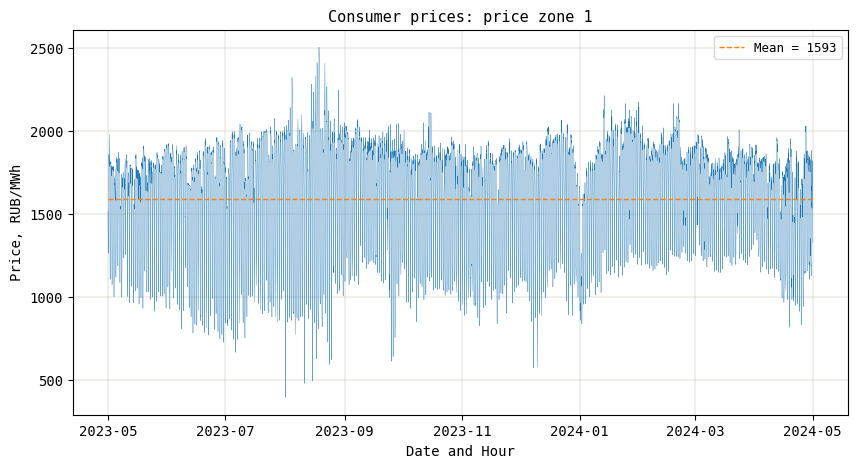

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(price_data_eur.index, price_data_eur['CONSUMER_PRICE'], color='C0', lw=0.25)
plt.hlines(price_data_eur['CONSUMER_PRICE'].mean(), xmin=price_data_eur.index.min(), xmax=price_data_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {price_data_eur['CONSUMER_PRICE'].mean():.0f}")
plt.xlabel('Date and Hour', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Consumer prices: price zone {price_zone}', size=11, family='monospace')
plt.legend(prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

Next, we'll check the hour distribution -- consumer price mean hourly profile.

In [11]:
price_data_daily_agg_eur = price_data_eur.groupby('HOUR')['CONSUMER_PRICE'].mean()
price_data_daily_agg_eur

HOUR
0     1244.706885
1     1142.310683
2     1081.862240
3     1058.018962
4     1085.111284
5     1185.857131
6     1331.013224
7     1540.080082
8     1729.485519
9     1830.166311
10    1857.536230
11    1863.038005
12    1849.733060
13    1861.542568
14    1867.866858
15    1862.852432
16    1864.292022
17    1856.555902
18    1855.611311
19    1847.650683
20    1805.406421
21    1730.848115
22    1539.855820
23    1352.347623
Name: CONSUMER_PRICE, dtype: float64

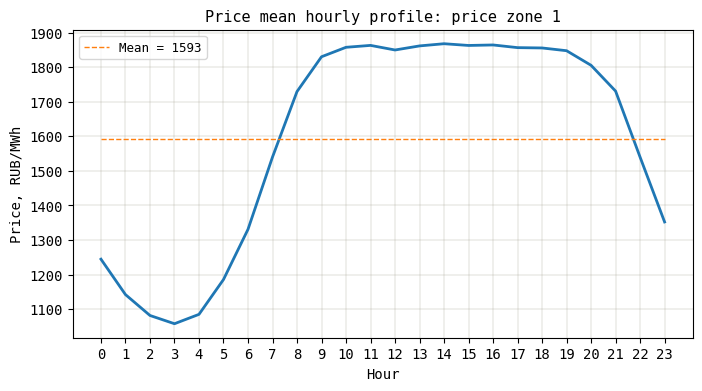

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(price_data_daily_agg_eur.index, price_data_daily_agg_eur, color='C0', lw=2)
plt.hlines(price_data_daily_agg_eur.mean(), xmin=price_data_daily_agg_eur.index.min(), xmax=price_data_daily_agg_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {price_data_daily_agg_eur.mean():.0f}")
plt.xlabel('Hour', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(price_data_daily_agg_eur.index, size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Price mean hourly profile: price zone {price_zone}', size=11, family='monospace')
plt.legend(prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

Let's examine the peak and off-peak hours.

In [13]:
hour_max_eur = price_data_daily_agg_eur.idxmax()
hour_min_eur = price_data_daily_agg_eur.idxmin()
hour_max_eur, hour_min_eur

(14, 3)

In [14]:
price_data_peak_eur = price_data_eur[price_data_eur['HOUR'] == hour_max_eur]
price_data_peak_eur

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
Datetime,,,,
2023-05-01 14:00:00,1,1803.61,14,0
2023-05-02 14:00:00,1,1793.39,14,1
2023-05-03 14:00:00,1,1770.27,14,2
2023-05-04 14:00:00,1,1674.88,14,3
2023-05-05 14:00:00,1,1810.13,14,4
...,...,...,...,...
2024-04-26 14:00:00,1,1862.04,14,4
2024-04-27 14:00:00,1,2025.49,14,5
2024-04-28 14:00:00,1,1810.51,14,6


In [15]:
price_data_peak_eur['CONSUMER_PRICE'].describe()

count     366.000000
mean     1867.866858
std       137.479673
min      1132.110000
25%      1793.745000
50%      1869.885000
75%      1944.390000
max      2504.960000
Name: CONSUMER_PRICE, dtype: float64

In [16]:
price_data_offpeak_eur = price_data_eur[price_data_eur['HOUR'] == hour_min_eur]
price_data_offpeak_eur

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
Datetime,,,,
2023-05-01 03:00:00,1,1275.81,3,0
2023-05-02 03:00:00,1,1113.04,3,1
2023-05-03 03:00:00,1,1085.05,3,2
2023-05-04 03:00:00,1,1003.91,3,3
2023-05-05 03:00:00,1,1121.00,3,4
...,...,...,...,...
2024-04-26 03:00:00,1,944.52,3,4
2024-04-27 03:00:00,1,1147.59,3,5
2024-04-28 03:00:00,1,1157.11,3,6


In [17]:
price_data_offpeak_eur['CONSUMER_PRICE'].describe()

count     366.000000
mean     1058.018962
std       153.703503
min       495.830000
25%       956.015000
50%      1066.625000
75%      1182.727500
max      1435.760000
Name: CONSUMER_PRICE, dtype: float64

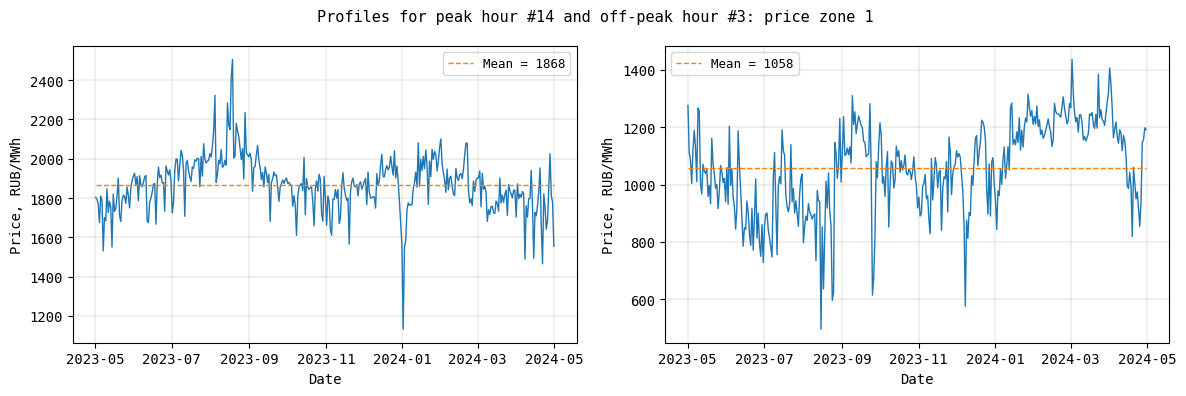

In [18]:
plt.figure(figsize=(12, 4))
for i, hour_profile in zip(range(1, 3), [price_data_peak_eur, price_data_offpeak_eur]):
    plt.subplot(1, 2, i)
    plt.plot(hour_profile.index, hour_profile['CONSUMER_PRICE'], color='C0', lw=1)
    plt.hlines(hour_profile['CONSUMER_PRICE'].mean(), xmin=hour_profile.index.min(), xmax=hour_profile.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {hour_profile['CONSUMER_PRICE'].mean():.0f}")
    plt.xlabel('Date', size=10, family='monospace')
    plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement');    
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Profiles for peak hour #{hour_max_eur} and off-peak hour #{hour_min_eur}: price zone {price_zone}', size=11, family='monospace')
plt.tight_layout();

For further modeling we will consider only the peak hour. During cross-validation we will consider both peak and off-peak hours.

##### <a id="price-data-adf"></a>2.2. Test For Stationarity

Apply augmented Dickey-Fuller test for stationarity of price zone 1 (European)

$\mathcal{H}_{0}$: non-stationary

$\mathcal{H}_{1}$: stationary

In [19]:
alpha = 0.05
print(f'Peak hour #{hour_max_eur}:', end='    ')
adf_stats, adf_pval, _, _, _, _ = adfuller(price_data_peak_eur['CONSUMER_PRICE'])
print(f'{adf_stats = :.2f}, {adf_pval = :.2f}', end=', ')
print('Stationary') if adf_pval < alpha else print('Non-stationary')
print(f'Off-peak hour #{hour_min_eur}:', end=' ')
adf_stats, adf_pval, _, _, _, _ = adfuller(price_data_offpeak_eur['CONSUMER_PRICE'])
print(f'{adf_stats = :.2f}, {adf_pval = :.2f}', end=', ')
print('Stationary') if adf_pval < alpha else print('Non-stationary')

Peak hour #14:    adf_stats = -2.56, adf_pval = 0.10, Non-stationary
Off-peak hour #3: adf_stats = -2.71, adf_pval = 0.07, Non-stationary


##### <a id="model-sv-base"></a>2.3. Modeling

The mean of $y_{t}$ is modeled as $0$ in the original model, which means that we have to either centralize the data to make it oscillate around $0$ or change this parameter to reflect our data real mean, which yields the following final SV Baseline model:

$\displaystyle y_{t} \sim \mathcal{N}(\bar{y}, e^{h_{t} / 2})$.

We have created a custom wrapper class inheriting from the scikit-learn's <span style="font-family:consolas;">BaseEstimator</span> and <span style="font-family:consolas;">RegressorMixin</span> classes to work with our Stan models using the scikit-learn's interfaces: <span style="font-family:consolas;">fit()</span>, <span style="font-family:consolas;">predict()</span>, <span style="font-family:consolas;">score()</span>, <span style="font-family:consolas;">cross_validate()</span> etc.

In [20]:
# SV Baseline model
with open('./models/sv_base_fit.stan', 'r') as fh:
  sv_base_code_fit = fh.read()
with open('./models/sv_base_predict.stan', 'r') as fh:
  sv_base_code_predict = fh.read()
#print(sv_base_code_fit)
#print(sv_base_code_predict)
num_samples = 1_000
model_sv_base_peak_eur = StanModel(kind='sv_base',
                                  name='SV Baseline',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

In [21]:
%%capture
# Learn parameters
model_sv_base_peak_eur.fit(X=price_data_peak_eur['CONSUMER_PRICE'], y=price_data_peak_eur['CONSUMER_PRICE'])

In [22]:
model_sv_base_peak_eur

StanModel(kind='sv_base', name='SV Baseline',
          stan_code_fit='/**\n'
                        ' * @file sv_base_fit.stan\n'
                        ' * @author Andrei Batyrov (arbatyrov@edu.hse.ru)\n'
                        ' * @brief SV Baseline model: Fit method\n'
                        ' * Exogenous regressors: None\n'
                        ' * @version 0.1\n'
                        ' * @date 2024-05-08\n'
                        ' * \n'
                        ' * @copyright Copyright (c) 2024\n'
                        ' * \n'
                        ' */\n'
                        '\n'
                        'data\n'
                        '{\n'
                        '  int<lower=1> N; // Number of train time points '
                        '(equal...
                            '  int<lower=1> N_pred; // Number of test time '
                            'points (equally spaced)\n'
                            '  vector[N_pred] h;    // Vector of learned log '
                            'volatility at time t\n'
                            '  real y_mean;         // Learned mean price\n'
                            '}\n'
                            '\n'
                            'generated quantities\n'
                            '{\n'
                            '  vector[N_pred] y_pred;\n'
                            '\n'
                            '  // Generate posterior predictive distribution\n'
                            '  for (t in 1:N_pred)\n'
                            '  {\n'
                            '      y_pred[t] = normal_rng(y_mean, exp(h[t] / '
                            '2));\n'
                            '  }\n'
                            '  \n'
                            '}')

In [23]:
fit_sv_base_peak_eur_df = model_sv_base_peak_eur.fit_result_df_
fit_sv_base_peak_eur_df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,phi,sigma,...,h.357,h.358,h.359,h.360,h.361,h.362,h.363,h.364,h.365,h.366
draws,,,,,,,,,,,,,,,,,,,,,
0,-2048.987072,0.998808,0.162794,5.0,31.0,0.0,2218.205321,9.409250,0.899576,0.510028,...,10.171760,9.761362,9.410159,9.572592,9.632585,9.607942,10.852149,11.492883,11.993282,11.938572
1,-2051.645520,0.785068,0.162794,5.0,31.0,0.0,2238.953193,9.487211,0.861444,0.689875,...,9.916836,10.182557,10.742638,10.911543,11.541358,11.319402,10.157329,9.669511,9.590177,10.396847
2,-2078.617586,0.936711,0.162794,5.0,31.0,0.0,2246.898599,9.033659,0.886703,0.533072,...,9.917153,9.708457,9.963123,10.795783,10.127860,10.138632,10.742932,9.514498,10.053345,10.269850
3,-2065.823102,0.974228,0.162794,5.0,31.0,0.0,2269.101908,9.373969,0.921994,0.538829,...,11.301413,10.719516,9.851357,10.527315,10.217348,9.208451,9.129752,8.981001,9.699747,9.606460
4,-2078.911922,0.623916,0.162794,5.0,31.0,0.0,2262.072333,9.597934,0.918899,0.561171,...,10.761057,10.848651,11.627593,11.226042,10.599984,10.524358,10.028912,10.298656,9.441375,10.218906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2094.658510,0.841583,0.162794,5.0,31.0,0.0,2269.486505,9.886911,0.938825,0.432126,...,10.670229,10.366236,10.347617,10.578081,11.001728,10.715108,10.056712,10.122348,10.457994,10.961588
996,-2060.396429,0.995562,0.162794,5.0,31.0,0.0,2252.368033,8.966615,0.827554,0.529706,...,10.492312,10.430130,10.314677,10.100092,8.912153,8.933623,9.666055,9.420899,9.952453,10.233650
997,-2056.457131,0.962217,0.162794,5.0,31.0,0.0,2239.633281,9.132582,0.895557,0.511179,...,9.955513,9.563039,9.598079,9.270466,10.243102,10.128444,9.285494,9.729757,9.800248,10.017575


In [24]:
# Learned parameters
fit_sv_base_peak_eur_df[['mu', 'phi', 'sigma']].describe()

parameters,mu,phi,sigma
count,1000.000000,1000.000000,1000.000000
mean,9.348617,0.881165,0.499893
std,0.275783,0.048779,0.107231
min,8.276047,0.715244,0.212606
25%,9.173458,0.853809,0.423141
50%,9.339528,0.888114,0.496753
75%,9.520876,0.916686,0.563613
max,10.401829,0.983804,0.889206


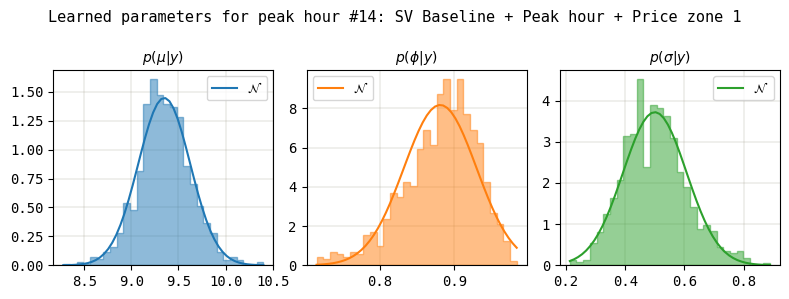

In [158]:
plt.figure(figsize=(8, 3))
for i, param in zip(range(1, 4), fit_sv_base_peak_eur_df[['mu', 'phi', 'sigma']].describe().columns):
    plt.subplot(1, 3, i)
    plt.hist(fit_sv_base_peak_eur_df[param], bins=30, density=True, histtype='stepfilled', color=f'C{i - 1}', edgecolor=f'C{i - 1}', alpha=0.5)
    x = np.linspace(fit_sv_base_peak_eur_df[param].min(), fit_sv_base_peak_eur_df[param].max())
    param_theor = norm(fit_sv_base_peak_eur_df[param].mean(), fit_sv_base_peak_eur_df[param].std(ddof=1))
    plt.plot(x, param_theor.pdf(x), color=f'C{i - 1}', label='$\mathcal{N}$')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.title(f'$p(\{param} | y)$', size=10, family='monospace')
    plt.legend(prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement')
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Learned parameters for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.tight_layout();

In [26]:
%%capture
# Predict
predict_sv_base_peak_eur_mean = model_sv_base_peak_eur.predict(price_data_peak_eur['CONSUMER_PRICE'])
predict_sv_base_peak_eur_mean.shape

In [27]:
%%capture
predict_sv_base_peak_eur_many = model_sv_base_peak_eur.predict_many(price_data_peak_eur['CONSUMER_PRICE'])
predict_sv_base_peak_eur_many.shape

In [28]:
%%capture
predict_sv_base_peak_eur_ci = model_sv_base_peak_eur.predict_ci(price_data_peak_eur['CONSUMER_PRICE'], [2.5, 97.5])
len(predict_sv_base_peak_eur_ci)

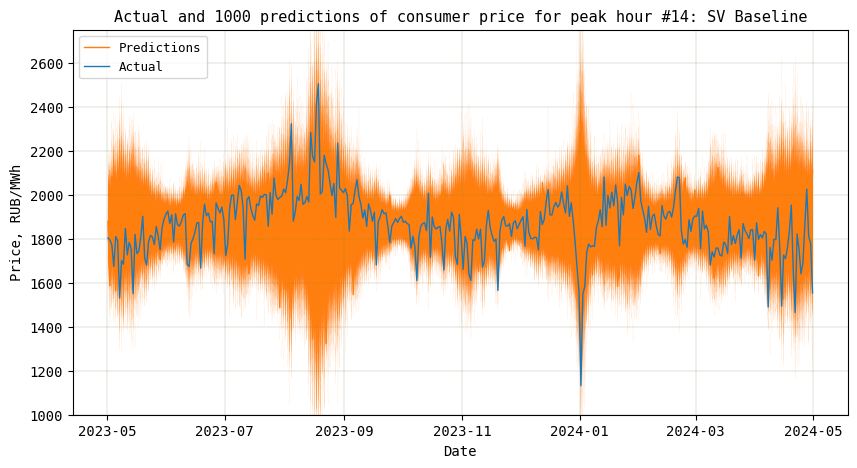

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(price_data_peak_eur.index, predict_sv_base_peak_eur_many[0], color='C1', lw=1, label='Predictions')
for i in range(1, predict_sv_base_peak_eur_many.shape[0]):
    plt.plot(price_data_peak_eur.index, predict_sv_base_peak_eur_many[i], color='C1', lw=0.025)
plt.plot(price_data_peak_eur.index, price_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Actual')
plt.xlabel('Date', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1000, 2750])
plt.title(f'Actual and {num_samples} predictions of consumer price for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

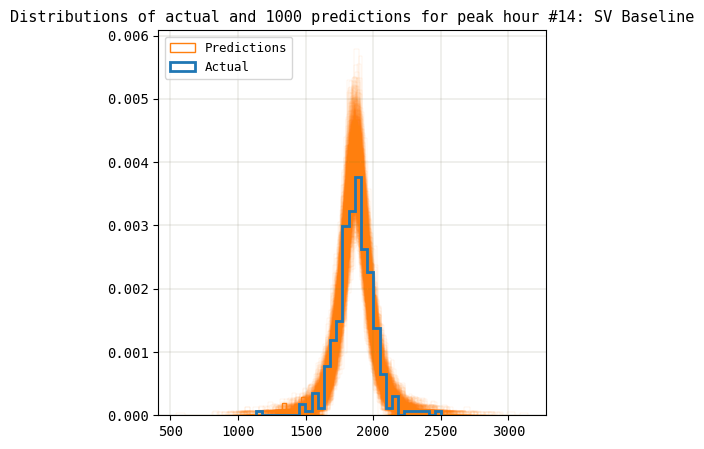

In [30]:
plt.figure(figsize=(5, 5))
plt.hist(predict_sv_base_peak_eur_many[0], bins=30, density=True, histtype='step', color='white', edgecolor='C1', lw=1, label='Predictions')
for i in range(1, predict_sv_base_peak_eur_many.shape[0]):
    plt.hist(predict_sv_base_peak_eur_many[i], bins=30, density=True, histtype='step', color='white', edgecolor='C1', lw=0.05)
plt.hist(price_data_peak_eur['CONSUMER_PRICE'], bins=30, density=True, histtype='step', color='white', edgecolor='C0', lw=2, label='Actual')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.grid(lw=0.25, color='xkcd:cement')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.gca().set_axisbelow(True)
plt.title(f'Distributions of actual and {num_samples} predictions for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace');

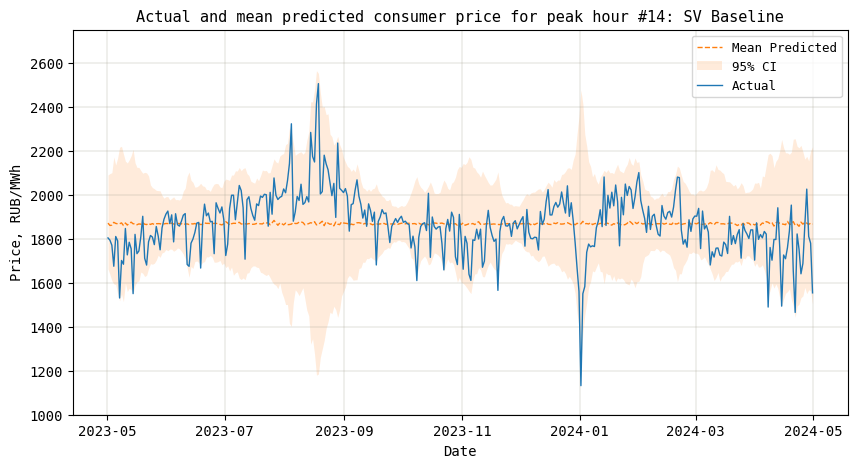

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(price_data_peak_eur.index, predict_sv_base_peak_eur_mean, color='C1', lw=1, ls='--', label='Mean Predicted')
plt.fill_between(price_data_peak_eur.index, predict_sv_base_peak_eur_ci[0], predict_sv_base_peak_eur_ci[1], color='C1', lw=0, alpha=0.15, label='95% CI')
plt.plot(price_data_peak_eur.index, price_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Actual')
plt.xlabel('Date', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1000, 2750])
plt.title(f'Actual and mean predicted consumer price for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

In [32]:
# Volatility at time t over all predictions
vol_sv_base_peak_eur = model_sv_base_peak_eur.get_volatility()
vol_sv_base_peak_eur.shape

(1000, 366)

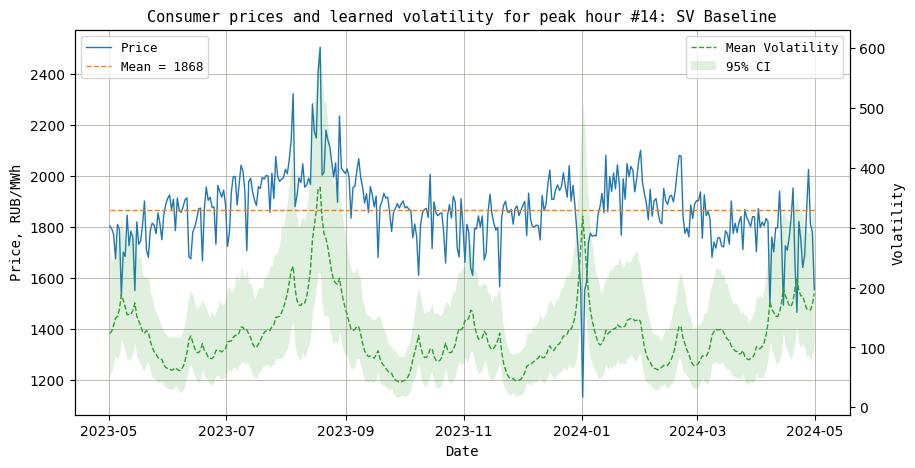

In [33]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(price_data_peak_eur.index, price_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Price')
ax.hlines(price_data_peak_eur['CONSUMER_PRICE'].mean(), xmin=price_data_peak_eur.index.min(), xmax=price_data_peak_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {price_data_peak_eur['CONSUMER_PRICE'].mean():.0f}")
ax.set_xlabel('Date', size=10, family='monospace')
ax.set_ylabel('Price, RUB/MWh', size=10, family='monospace')
ax.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
ax.grid(lw=0.5, color='xkcd:cement')
ax2 = ax.twinx()
ax2.plot(price_data_peak_eur.index, vol_sv_base_peak_eur.mean(axis=0), color='C2', lw=1, ls='--', label='Mean Volatility')
ax2.fill_between(price_data_peak_eur.index, np.percentile(vol_sv_base_peak_eur, [2.5, 97.5], axis=0)[0], np.percentile(vol_sv_base_peak_eur, [2.5, 97.5], axis=0)[1], color='C2', lw=0, alpha=0.15, label='95% CI')
ax2.set_ylabel('Volatility', size=10, family='monospace')
ax2.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
ax.set_title(f'Consumer prices and learned volatility for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace');

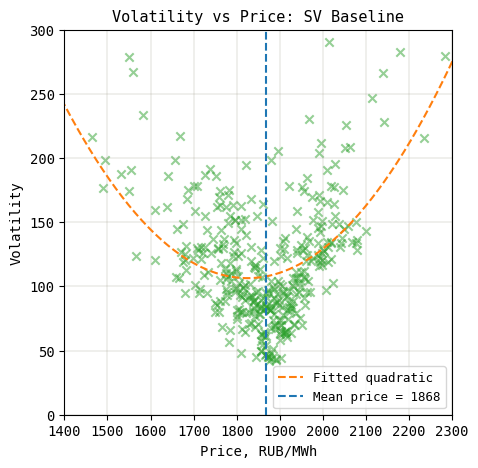

In [34]:
plt.figure(figsize=(5, 5))
fitted_quadratic = np.poly1d(np.polyfit(price_data_peak_eur['CONSUMER_PRICE'], vol_sv_base_peak_eur.mean(axis=0), deg=2))
x = np.linspace(price_data_peak_eur['CONSUMER_PRICE'].min(), price_data_peak_eur['CONSUMER_PRICE'].max(), price_data_peak_eur['CONSUMER_PRICE'].shape[0])
plt.scatter(price_data_peak_eur['CONSUMER_PRICE'], vol_sv_base_peak_eur.mean(axis=0), color='C2', marker='x', alpha=0.5)
plt.plot(x, fitted_quadratic(x), color='C1', ls='--', label='Fitted quadratic')
plt.vlines(price_data_peak_eur['CONSUMER_PRICE'].mean(), ymin=0, ymax=350, color='C0', ls='--', label=f"Mean price = {price_data_peak_eur['CONSUMER_PRICE'].mean():.0f}")
plt.xlabel('Price, RUB/MWh', size=10, family='monospace')
plt.ylabel('Volatility', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xlim([1400, 2300])
plt.ylim([0, 300])
plt.title(f'Volatility vs Price: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='lower right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

We can clearly see that volatility _does_ depend on consumer price, and our **SV Baseline** model discovered this relation.

We can see a rather V-shaped dependency: the volatility tends to increase for the prices higher and lower than the mean price, while it's minimal around the mean price.

##### <a id="eval-sv-base"></a>2.4. Goodness-of-fit

Consider the following metrics for evaluating the quality of the model.

1) Mean Absolute Error: $\displaystyle MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y_{i}}|$, where

    $n$ is the number of target points, $y_{i}$ are the true target values, $\hat{y_{i}}$ are the model's predictions.
2) Rooted Mean Squared Error: $\displaystyle RMSE = \sqrt{MSE}$, where 

    Mean Squared Error: $\displaystyle MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^2$.

In [35]:
# MAE for mean predictions over all predictions
mae_sv_base = mean_absolute_error(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean)
print(f'{mae_sv_base = :.2f}')

mae_sv_base = 99.18


In [36]:
# RMSE for mean predictions over all predictions
rmse_sv_base = root_mean_squared_error(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean, )
print(f'{rmse_sv_base = :.2f}')

rmse_sv_base = 137.04


Let's check the correlation between mean predicted and actual prices.

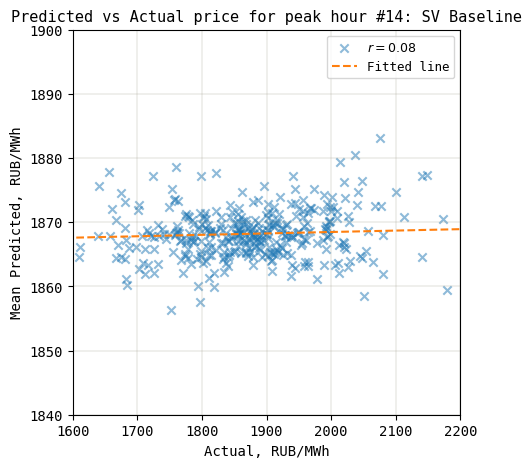

In [37]:
r = np.corrcoef(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean)[0, 1]
fitted_line = np.poly1d(np.polyfit(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean, deg=1))
x = np.linspace(price_data_peak_eur['CONSUMER_PRICE'].min(), price_data_peak_eur['CONSUMER_PRICE'].max(), price_data_peak_eur['CONSUMER_PRICE'].shape[0])
plt.figure(figsize=(5, 5))
plt.scatter(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean, color='C0', marker='x', alpha=0.5, label=f'$r = {r:.2f}$')
plt.plot(x, fitted_line(x), color='C1', ls='--', label='Fitted line')
plt.xlabel('Actual, RUB/MWh', size=10, family='monospace')
plt.ylabel('Mean Predicted, RUB/MWh', size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.xlim([1600, 2200])
plt.ylim([1840, 1900])
plt.title(f'Predicted vs Actual price for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

Though the model was able to learn heteroscedasticity of the volatility, the correlation between the mean predictions and actual prices is rather weak.

We should also check the distribution of residuals, probability plot (similar to Q-Q plot), and residuals vs mean predicted prices.

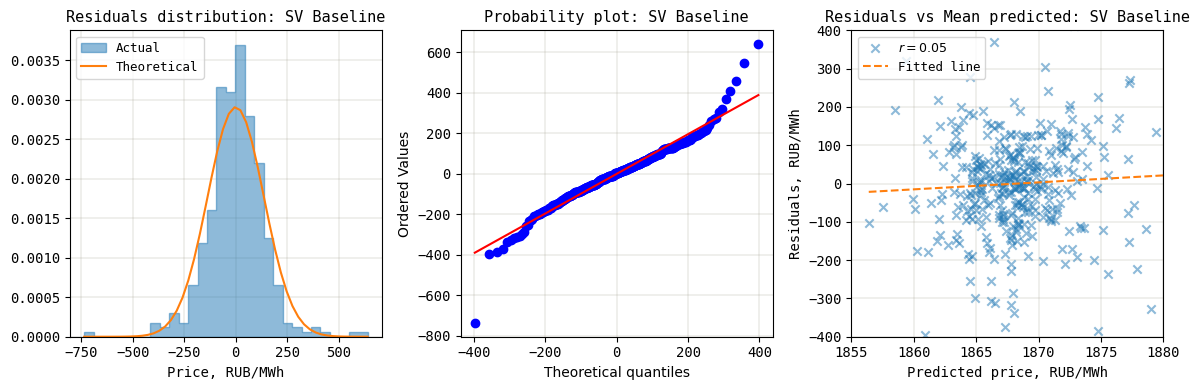

In [38]:
residuals_sv_base = price_data_peak_eur['CONSUMER_PRICE'] - predict_sv_base_peak_eur_mean
x = np.linspace(residuals_sv_base.min(), residuals_sv_base.max())
residuals_sv_base_theor = norm(residuals_sv_base.mean(), residuals_sv_base.std(ddof=1))
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(residuals_sv_base, bins=30, density=True, histtype='stepfilled', color='C0', edgecolor='C0', alpha=0.5, label='Actual')
plt.plot(x, residuals_sv_base_theor.pdf(x), color='C1', label='Theoretical')
plt.xlabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Residuals distribution: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.subplot(1, 3, 2)
probplot(residuals_sv_base, dist=residuals_sv_base_theor, plot=plt)
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Probability plot: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.subplot(1, 3, 3)
r = np.corrcoef(residuals_sv_base, predict_sv_base_peak_eur_mean)[0, 1]
fitted_line = np.poly1d(np.polyfit(predict_sv_base_peak_eur_mean, residuals_sv_base, deg=1))
x = np.linspace(predict_sv_base_peak_eur_mean.min(), predict_sv_base_peak_eur_mean.max(), predict_sv_base_peak_eur_mean.shape[0])
plt.scatter(predict_sv_base_peak_eur_mean, residuals_sv_base, color='C0', marker='x', alpha=0.5, label=f'$r = {r:.2f}$')
plt.plot(x, fitted_line(x), color='C1', ls='--', label='Fitted line')
plt.xlabel('Predicted price, RUB/MWh', size=10, family='monospace')
plt.ylabel('Residuals, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xlim([1855, 1880])
plt.ylim([-400, 400])
plt.title(f'Residuals vs Mean predicted: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.tight_layout();

Residuals look to be distributed more or less normally. Also they look rather homoscedastic w.r.t predictions, which means that the model is rather acceptable.

[Back](#toc)

---
##### <a id="sv-x"></a>3. SV Exogenous Model

Next, we will consider an extension of the SV Baseline model. The idea of adding exogenous regressor(s) is inspired by the paper "Probabilistic electricity price forecasting with Bayesian stochastic volatility models" by Maciej Kostrzewski, Jadwiga Kostrzewska, 2019.

The authors propose a stochastic volatility model with a double exponential distribution of jumps, a leverage effect and exogenous variables (in short, the SVDEJX model). This model introduces one exogenous factor -- the logarithm of the hourly air temperature at time $t$. The model also introduces indicator variables for 3 days of the week: Sat, Sun, Mon.

First, we'll examine the first possible exogenous regressor -- air temperature.

##### <a id="load-temp-data"></a>3.1. Temperature Data

In [39]:
# Price zone 1: Moscow
temp_data_eur = pd.read_csv(f'./data/UUEE.01.05.2023.07.05.2024.1.0.0.ru.utf8.00000000.zip', 
                        sep=';', 
                        encoding='utf-8',
                        skiprows=7, 
                        index_col=0, 
                        dayfirst=True, 
                        usecols=[0, 1], 
                        names=['Datetime', 'Temperature'], 
                        parse_dates=True).dropna().sort_index()

In [40]:
temp_data_eur = temp_data_eur.loc[:'30.04.2024'] # 01.05.2024 -- 07.05.2024 is used for forecasting
temp_data_eur

,Temperature
Datetime,
2023-05-01 00:00:00,6.0
2023-05-01 00:30:00,6.0
2023-05-01 01:00:00,6.0
2023-05-01 01:30:00,6.0
2023-05-01 02:00:00,6.0
...,...
2024-04-30 21:30:00,18.0
2024-04-30 22:00:00,19.0
2024-04-30 22:30:00,19.0


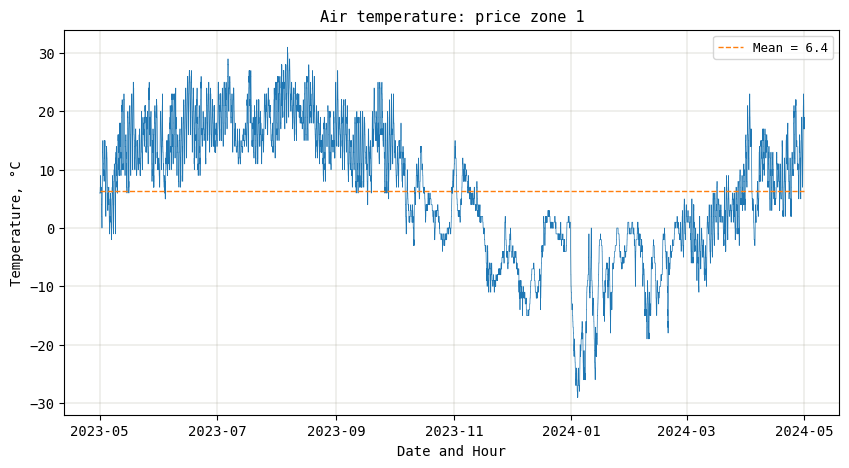

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(temp_data_eur.index, temp_data_eur['Temperature'], color='C0', lw=0.5)
plt.hlines(temp_data_eur['Temperature'].mean(), xmin=temp_data_eur.index.min(), xmax=temp_data_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {temp_data_eur['Temperature'].mean():.1f}")
plt.xlabel('Date and Hour', size=10, family='monospace')
plt.ylabel('Temperature, °C', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Air temperature: price zone {price_zone}', size=11, family='monospace')
plt.legend(prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

In [42]:
# Join consumer price and air temperature data
price_temp_data_eur = pd.merge(price_data_eur, temp_data_eur, on='Datetime')
price_temp_data_eur.shape

(8760, 5)

In [43]:
price_temp_data_eur.head(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday,Temperature
Datetime,,,,,
2023-05-01 00:00:00,1,1517.92,0,0,6.0
2023-05-01 01:00:00,1,1413.99,1,0,6.0
2023-05-01 02:00:00,1,1345.22,2,0,6.0
2023-05-01 03:00:00,1,1275.81,3,0,6.0


In [44]:
price_temp_data_eur.tail(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday,Temperature
Datetime,,,,,
2024-04-30 20:00:00,1,1822.91,20,1,18.0
2024-04-30 21:00:00,1,1742.75,21,1,17.0
2024-04-30 22:00:00,1,1442.53,22,1,19.0
2024-04-30 23:00:00,1,1327.94,23,1,18.0


In [45]:
price_temp_data_peak_eur = price_temp_data_eur[price_temp_data_eur['HOUR'] == hour_max_eur]
price_temp_data_peak_eur

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday,Temperature
Datetime,,,,,
2023-05-01 14:00:00,1,1803.61,14,0,7.0
2023-05-02 14:00:00,1,1793.39,14,1,14.0
2023-05-03 14:00:00,1,1770.27,14,2,12.0
2023-05-04 14:00:00,1,1674.88,14,3,13.0
2023-05-05 14:00:00,1,1810.13,14,4,4.0
...,...,...,...,...,...
2024-04-26 14:00:00,1,1862.04,14,4,22.0
2024-04-27 14:00:00,1,2025.49,14,5,10.0
2024-04-28 14:00:00,1,1810.51,14,6,15.0


In [46]:
price_temp_data_offpeak_eur = price_temp_data_eur[price_temp_data_eur['HOUR'] == hour_min_eur]
price_temp_data_offpeak_eur

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday,Temperature
Datetime,,,,,
2023-05-01 03:00:00,1,1275.81,3,0,6.0
2023-05-02 03:00:00,1,1113.04,3,1,2.0
2023-05-03 03:00:00,1,1085.05,3,2,9.0
2023-05-04 03:00:00,1,1003.91,3,3,4.0
2023-05-05 03:00:00,1,1121.00,3,4,5.0
...,...,...,...,...,...
2024-04-26 03:00:00,1,944.52,3,4,11.0
2024-04-27 03:00:00,1,1147.59,3,5,15.0
2024-04-28 03:00:00,1,1157.11,3,6,6.0


Let's check the correlation between the Price and Temperature. We are expecting a rather V-shaped dependency, since both high and low air temperatures should increase electricity demand for cooling and heating and thus the price.

/tmp/ipykernel_74429/4233981735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_temp_data_peak_eur.loc[:, 'Cluster'] = KMeans(n_clusters=2, random_state=0).fit_predict(price_temp_data_peak_eur[['Temperature']])


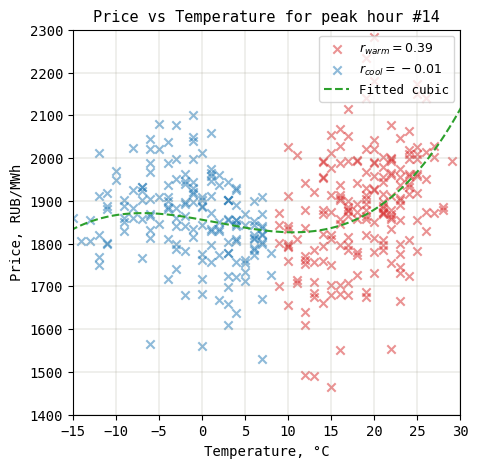

In [47]:
price_temp_data_peak_eur.loc[:, 'Cluster'] = KMeans(n_clusters=2, random_state=0).fit_predict(price_temp_data_peak_eur[['Temperature']])
r_warm = price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].max()]['CONSUMER_PRICE'].corr(price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].max()]['Temperature'])
r_cool = price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].min()]['CONSUMER_PRICE'].corr(price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].min()]['Temperature'])
fitted_cubic = np.poly1d(np.polyfit(price_temp_data_peak_eur['Temperature'], price_temp_data_peak_eur['CONSUMER_PRICE'], deg=3))
x = np.linspace(price_temp_data_peak_eur['Temperature'].min(), price_temp_data_peak_eur['Temperature'].max(), price_temp_data_peak_eur['Temperature'].shape[0])
plt.figure(figsize=(5, 5))
plt.scatter(price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].max()]['Temperature'], price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].max()]['CONSUMER_PRICE'], color='C3', marker='x', alpha=0.5, label=f'$r_{{warm}} = {r_warm:.2f}$')
plt.scatter(price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].min()]['Temperature'], price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].min()]['CONSUMER_PRICE'], color='C0', marker='x', alpha=0.5, label=f'$r_{{cool}} = {r_cool:.2f}$')
plt.plot(x, fitted_cubic(x), color='C2', ls='--', label='Fitted cubic')
plt.xlabel('Temperature, °C', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.xlim([-15, 30])
plt.ylim([1400, 2300])
plt.title(f'Price vs Temperature for peak hour #{hour_max_eur}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

We can confirm that the price _does_ depend on the air temperature:
- coefficient of correlation (Pearson) for high air temperatures is 0.39,
- coefficient of correlation (Pearson) for low air temperatures is -0.01.

The price tends to be higher for higher and lower air temperatures, which looks reasonable: electricity demand is higher during the hot and cold season of the year (both cooling and heating are required), while the demand is minimal during semi-seasons when minimal heating and cooling are required. At the same time, the price responds more to the higher air temperatures. This might be due to the fact that in the studied scenario electricity is used more for cooling than for heating.

Next, let's examine the second possible exogenous regressor -- the day of the week.

##### <a id="load-weekday-data"></a>3.2. Weekday

In [48]:
price_temp_data_peak_eur['day_name'] = price_temp_data_peak_eur.index.day_name()
price_temp_data_peak_eur

/tmp/ipykernel_74429/884510011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_temp_data_peak_eur['day_name'] = price_temp_data_peak_eur.index.day_name()


,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday,Temperature,Cluster,day_name
Datetime,,,,,,,
2023-05-01 14:00:00,1,1803.61,14,0,7.0,0,Monday
2023-05-02 14:00:00,1,1793.39,14,1,14.0,1,Tuesday
2023-05-03 14:00:00,1,1770.27,14,2,12.0,1,Wednesday
2023-05-04 14:00:00,1,1674.88,14,3,13.0,1,Thursday
2023-05-05 14:00:00,1,1810.13,14,4,4.0,0,Friday
...,...,...,...,...,...,...,...
2024-04-26 14:00:00,1,1862.04,14,4,22.0,1,Friday
2024-04-27 14:00:00,1,2025.49,14,5,10.0,1,Saturday
2024-04-28 14:00:00,1,1810.51,14,6,15.0,1,Sunday


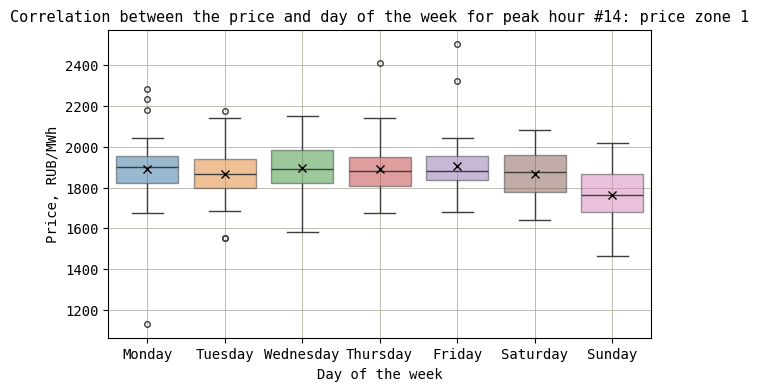

In [49]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=price_temp_data_peak_eur[['CONSUMER_PRICE', 'Weekday', 'day_name']].sort_values(by='Weekday'), x='day_name', y='CONSUMER_PRICE', hue='day_name', flierprops={'marker': 'o', 'markersize': 4}, showmeans=True, meanprops={'marker': 'x', 'markeredgecolor': 'k', 'markerfacecolor': 'k', 'markersize': 6}, boxprops=dict(alpha=0.5))
plt.xlabel('Day of the week', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.grid(lw=0.5, color='xkcd:cement')
plt.title(f'Correlation between the price and day of the week for peak hour #{hour_max_eur}: price zone 1', size=11, family='monospace');

Though the mean values look equal, at least on Sundays the price tends to be lower. Let's introduce the second new regressor -- day of the week.

##### <a id="ar-1"></a>3.3. Autoregressive Component

Kostrzewski et al. extend their model with the minimum of the previous day's 24 hourly log prices [p. 615]. Based on this idea, we will check the correlation between the prices at time $t$ (today) and $t-1$ (yesterday). For that, we'll compute the partial autocorrelation function which is the correlation between two observations that the shorter lags between those observations do not explain, i.e. the partial correlation for each lag is the unique correlation between those two observations after removing out the intervening correlations.

In [50]:
# PACF for Peak hour + Price zone 1 with CI at 5% significance level for 42 day lags
pacf_corr_price_temp_data_peak_eur, pacf_ci_price_temp_data_peak_eur = pacf(price_temp_data_peak_eur['CONSUMER_PRICE'], nlags=42, alpha=0.05)

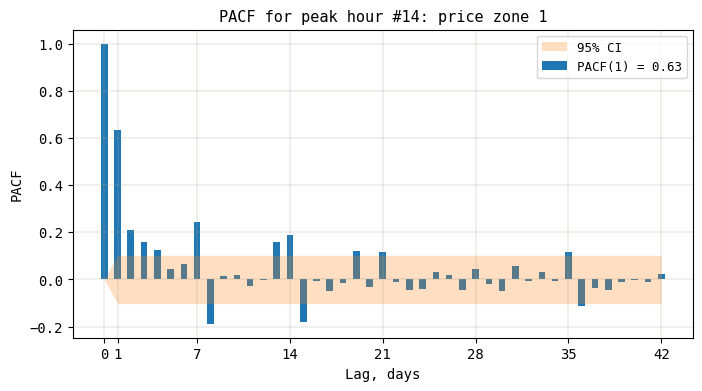

In [51]:
plt.figure(figsize=(8, 4))
plt.bar(x=range(0, 43), height=pacf_corr_price_temp_data_peak_eur, width=0.5, align='center', label=f'PACF(1) = {pacf_corr_price_temp_data_peak_eur[1]:.2f}')
plt.fill_between(range(0, 43), pacf_corr_price_temp_data_peak_eur - pacf_ci_price_temp_data_peak_eur[:, 0], pacf_corr_price_temp_data_peak_eur - pacf_ci_price_temp_data_peak_eur[:, 1], color='C1', lw=0, alpha=0.25, label='95% CI')
plt.xlabel('Lag, days', size=10, family='monospace')
plt.ylabel('PACF', size=10, family='monospace')
plt.xticks([0, 1, 7, 14, 21, 28, 35, 42], size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'PACF for peak hour #{hour_max_eur}: price zone 1', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

Since our price is not stationary [2.2], the PACF decays rather slowly during the period of 42 days (6 weeks). We have shown above [3.2] that the price _is_ correlated with the day of the week. Observe that the PACF has spikes exactly every 7 days (1 week) which further supports the correctness of inclusion of the day of the week as an exogenous regressor.

PACF suggests that using at least 7 or more lags (new features) might be possible. We already decided to include the day of the week to explain the seasonality of the price. The strongest correlation is seen for the lag of one (0.63), while other lags are much weaker correlated. Taking into account computational complexity of inference with Stan, using only the lag of one day looks to be a reasonable compromise. In other words, we will consider an autoregressive model with lag of one AR(1) as the autoregressive component.

A first-order autoregressive model AR(1) is the following:

$\displaystyle y_{t} = \mathcal{N}(\alpha + \beta y_{t-1}, \sigma)$, where

$\alpha$ and $\beta$ are the intercept and slope of autoregression and $\sigma \sim \mathcal{N}(0, 1)$ (constant normal volatility). Since we model volatility as a stochastic process (not simply constant), we will use only the expected value of this model.

We have shown that the consumer price is correlated with the air temperature [3.1], day of the week [3.2], and with itself with at least lag of one day [3.3]. Let's propose a new model **SV X**, which extends our SV Baseline model with three exogenous regressors -- air temperature, day of the week, and autoregressive component:

$\displaystyle y_{t} \sim \mathcal{N}(\bar{y} + \alpha y_{t-1} + \beta_3 X_{t-1}^3 + \beta_2 X_{t-1}^2 + \beta_1 X_{t-1} + \gamma D_{t} + \xi, e^{h_{t} / 2})$, where

$X_{t-1}$ is the hourly air temperature at time $t-1$. To prevent target leakage, the temperature readings are lagged one day behind ($t-1$);

$D_{t}$ is the day of the week at time $t$.

Thus, we are introducing 6 new model parameters:
- $\alpha$ for the autoregressive component;
- $\beta_{i = 1 \ldots 3}$ for the air temperature regressor. The unit of air temperature is °C;
- $\gamma$ for the day of the week regressor. The weekdays are numbered from 0 (Monday) to 6 (Sunday);
- $\xi$ for the constant term (intercept) for all exogenous regressors.

##### <a id="model-sv-x"></a>3.4. Modeling

In [52]:
# SV Exogenous model
with open('./models/sv_x_fit.stan', 'r') as fh:
  sv_x_code_fit = fh.read()
with open('./models/sv_x_predict.stan', 'r') as fh:
  sv_x_code_predict = fh.read()
#print(sv_x_code_fit)
#print(sv_x_code_predict)
num_samples = 1_000
model_sv_x_peak_eur = StanModel(kind='sv_x', 
                                name='SV X',
                                stan_code_fit=sv_x_code_fit,
                                stan_code_predict=sv_x_code_predict, 
                                num_samples=num_samples)

In [53]:
%%capture
# Learn parameters
model_sv_x_peak_eur.fit(X=price_temp_data_peak_eur[['Temperature', 'Weekday']], y=price_temp_data_peak_eur['CONSUMER_PRICE'])

In [54]:
model_sv_x_peak_eur

StanModel(kind='sv_x', name='SV X',
          stan_code_fit='/**\n'
                        ' * @file sv_x_fit.stan\n'
                        ' * @author Andrei Batyrov (arbatyrov@edu.hse.ru)\n'
                        ' * @brief SV Exogenous model: Fit method\n'
                        ' * Exogenous regressors:\n'
                        ' * - Temperature\n'
                        ' * - Weekday\n'
                        ' * - AR(1)\n'
                        ' * @version 0.1\n'
                        ' * @date 2024-05-08\n'
                        ' * \n'
                        ' * @copyright Copyright (c) 2024\n'
                        ' * \n'
                        ' */\n'
                        '\n'
                        'data\n'
                        '{\n'
                        '  int<lower=1> N;        // Number...
                            '  // and continue from index 2\n'
                            '  y_pred[1] = normal_rng(y_mean + gamma * '
                            'Weekday_pred[1], \n'
                            '                         exp(h[1] / 2));\n'
                            '  for (t in 2:N_pred)\n'
                            '  {\n'
                            '    y_pred[t] = normal_rng(y_mean + \n'
                            '                           alpha * y_pred[t - 1] '
                            '+\n'
                            '                           beta_3 * '
                            'pow(Temperature_pred[t - 1], 3) + \n'
                            '                           beta_2 * '
                            'pow(Temperature_pred[t - 1], 2) + \n'
                            '                           beta_1 * '
                            'Temperature_pred[t - 1] + \n'
                            '                           gamma * '
                            'Weekday_pred[t] +\n'
                            '                           xi, \n'
                            '                           exp(h[t] / 2));\n'
                            '  }\n'
                            '}')

In [55]:
fit_sv_x_peak_eur_df = model_sv_x_peak_eur.fit_result_df_
fit_sv_x_peak_eur_df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,phi,sigma,...,h.357,h.358,h.359,h.360,h.361,h.362,h.363,h.364,h.365,h.366
draws,,,,,,,,,,,,,,,,,,,,,
0,-1958.858614,0.968849,0.026799,7.0,127.0,0.0,2155.869613,8.432058,0.857425,0.436684,...,10.453274,10.562207,10.097202,9.983324,8.509113,8.517375,8.487115,9.038675,9.301225,9.479741
1,-1981.437741,0.962916,0.026799,7.0,127.0,0.0,2159.376748,8.782540,0.891776,0.404979,...,9.094830,9.561118,8.665405,8.923757,9.513619,9.416216,10.312874,9.758503,10.527161,10.879657
2,-1991.197662,0.997666,0.026799,7.0,127.0,0.0,2180.665629,8.304263,0.917425,0.320711,...,9.915014,9.570548,10.184539,10.238794,9.986800,9.830399,9.125618,9.823665,9.380312,9.246397
3,-1948.205885,0.928831,0.026799,7.0,127.0,0.0,2159.161073,8.971959,0.904425,0.336091,...,9.894384,9.534264,9.422050,9.881279,9.406517,9.642888,10.039901,10.089156,10.181913,10.183830
4,-1963.159089,0.986114,0.026799,7.0,127.0,0.0,2143.784897,9.050988,0.897441,0.360818,...,10.600389,10.723295,10.808966,11.060201,11.282318,11.198639,10.410152,10.704294,10.468333,10.355598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1941.548370,1.000000,0.026799,7.0,127.0,0.0,2145.449405,8.690963,0.591980,0.766832,...,10.325532,9.470138,9.696057,9.721206,8.302099,9.166955,8.983652,8.904200,8.915673,10.229758
996,-1920.339048,0.993652,0.026799,7.0,127.0,0.0,2111.082057,8.749221,0.725355,0.699108,...,9.417973,9.364130,9.646698,9.032529,9.728846,9.527667,9.862187,9.925892,10.120725,9.660726
997,-1945.402821,0.991550,0.026799,7.0,127.0,0.0,2097.301868,8.741005,0.585005,0.618160,...,10.211061,10.044614,9.290724,9.061889,9.246372,10.061777,9.012879,9.216163,9.348223,9.922846


In [56]:
# Learned parameters
fit_sv_x_peak_eur_df[['mu', 'phi', 'sigma', 'alpha', 'beta_1', 'beta_2', 'beta_3', 'gamma', 'xi']].describe()

parameters,mu,phi,sigma,alpha,beta_1,beta_2,beta_3,gamma,xi
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.674955,0.685212,0.625996,0.617247,-2.181777,0.041367,0.005162,-20.393082,-1098.984503
std,0.154522,0.124779,0.142119,0.041495,0.737174,0.041200,0.002154,2.169565,76.449915
min,8.151622,0.212766,0.237326,0.472789,-4.939281,-0.120805,-0.003441,-26.919342,-1295.861230
25%,8.573767,0.608953,0.524341,0.589491,-2.652985,0.015148,0.003750,-21.951274,-1150.482584
50%,8.678518,0.700238,0.618743,0.617323,-2.171834,0.041098,0.005109,-20.347656,-1099.340551
75%,8.774036,0.778162,0.721254,0.644932,-1.665593,0.067884,0.006619,-18.824621,-1048.284500
max,9.319936,0.949155,1.174375,0.726671,0.212885,0.255716,0.011287,-14.239887,-838.702945


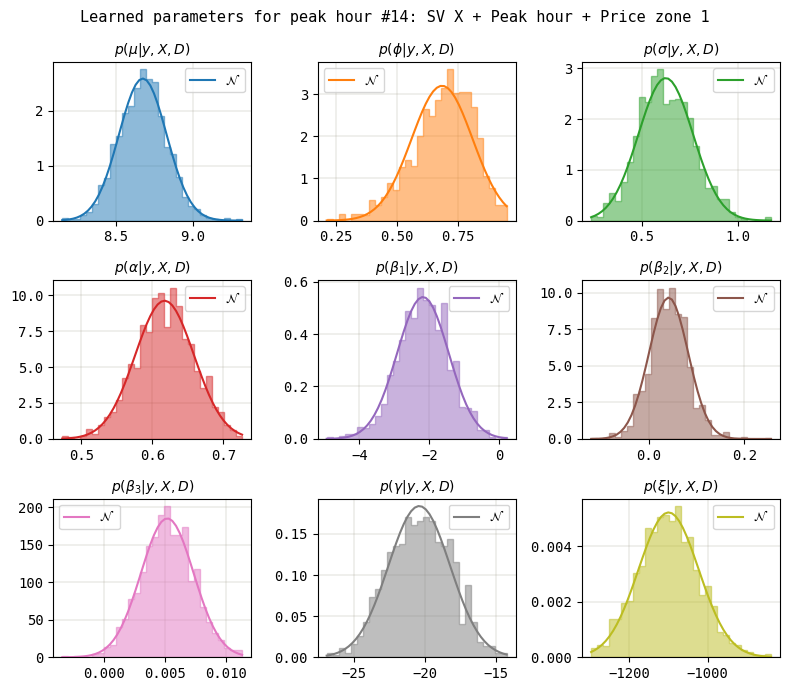

In [162]:
plt.figure(figsize=(8, 7))
ncols = 3
nrows = int(np.ceil(9 / ncols))
for i, param in zip(range(1, 10), fit_sv_x_peak_eur_df[['mu', 'phi', 'sigma', 'alpha', 'beta_1', 'beta_2', 'beta_3', 'gamma', 'xi']].describe().columns):
    plt.subplot(nrows, ncols, i)
    plt.hist(fit_sv_x_peak_eur_df[param], bins=30, density=True, histtype='stepfilled', color=f'C{i - 1}', edgecolor=f'C{i - 1}', alpha=0.5)
    x = np.linspace(fit_sv_x_peak_eur_df[param].min(), fit_sv_x_peak_eur_df[param].max())
    param_theor = norm(fit_sv_x_peak_eur_df[param].mean(), fit_sv_x_peak_eur_df[param].std(ddof=1))
    plt.plot(x, param_theor.pdf(x), color=f'C{i - 1}', label='$\mathcal{N}$')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.title(f'$p(\{param} | y, X, D)$', size=10, family='monospace')
    plt.legend(prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement')
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Learned parameters for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.tight_layout();

In [60]:
%%capture
# Predict
predict_sv_x_peak_eur_mean = model_sv_x_peak_eur.predict(price_temp_data_peak_eur[['Temperature', 'Weekday']])
predict_sv_x_peak_eur_mean.shape

In [61]:
%%capture
predict_sv_x_peak_eur_many = model_sv_x_peak_eur.predict_many(price_temp_data_peak_eur[['Temperature', 'Weekday']])
predict_sv_x_peak_eur_many.shape

In [62]:
%%capture
predict_sv_x_peak_eur_ci = model_sv_x_peak_eur.predict_ci(price_temp_data_peak_eur[['Temperature', 'Weekday']], [2.5, 97.5])
len(predict_sv_x_peak_eur_ci)

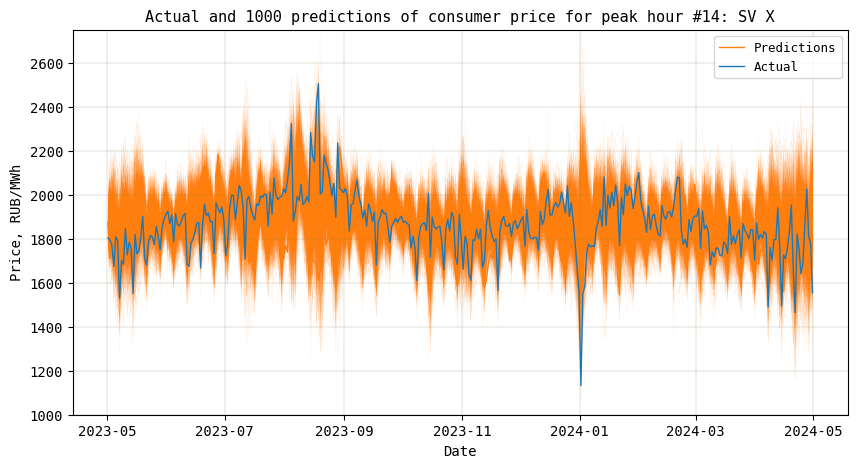

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(price_temp_data_peak_eur.index, predict_sv_x_peak_eur_many[0], color='C1', lw=1, label='Predictions')
for i in range(1, predict_sv_x_peak_eur_many.shape[0]):
    plt.plot(price_temp_data_peak_eur.index, predict_sv_x_peak_eur_many[i], color='C1', lw=0.025)
plt.plot(price_temp_data_peak_eur.index, price_temp_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Actual')
plt.xlabel('Date', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1000, 2750])
plt.title(f'Actual and {num_samples} predictions of consumer price for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

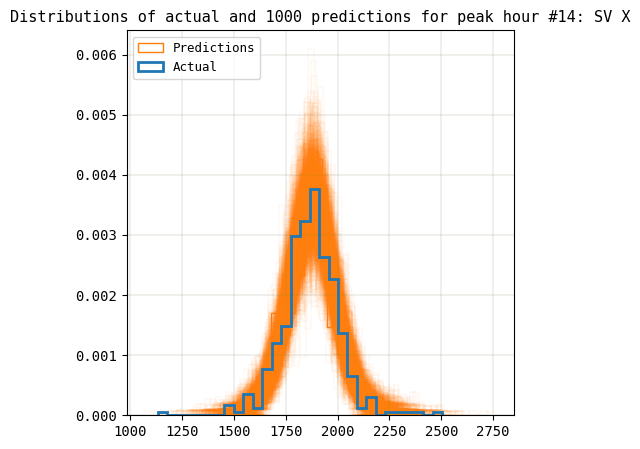

In [66]:
plt.figure(figsize=(5, 5))
plt.hist(predict_sv_x_peak_eur_many[0], bins=30, density=True, histtype='step', color='white', edgecolor='C1', lw=1, label='Predictions')
for i in range(1, predict_sv_x_peak_eur_many.shape[0]):
    plt.hist(predict_sv_x_peak_eur_many[i], bins=30, density=True, histtype='step', color='white', edgecolor='C1', lw=0.05)
plt.hist(price_temp_data_peak_eur['CONSUMER_PRICE'], bins=30, density=True, histtype='step', color='white', edgecolor='C0', lw=2, label='Actual')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.grid(lw=0.25, color='xkcd:cement')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.gca().set_axisbelow(True)
plt.title(f'Distributions of actual and {num_samples} predictions for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace');

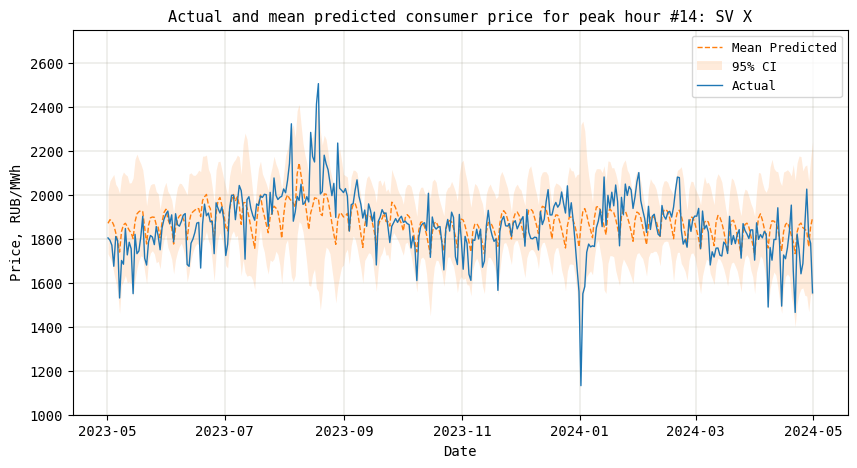

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(price_temp_data_peak_eur.index, predict_sv_x_peak_eur_mean, color='C1', lw=1, ls='--', label='Mean Predicted')
plt.fill_between(price_temp_data_peak_eur.index, predict_sv_x_peak_eur_ci[0], predict_sv_x_peak_eur_ci[1], color='C1', lw=0, alpha=0.15, label='95% CI')
plt.plot(price_temp_data_peak_eur.index, price_temp_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Actual')
plt.xlabel('Date', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1000, 2750])
plt.title(f'Actual and mean predicted consumer price for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

In [68]:
# Volatility at time t over all predictions
vol_sv_x_peak_eur = model_sv_x_peak_eur.get_volatility()
vol_sv_x_peak_eur.shape

(1000, 366)

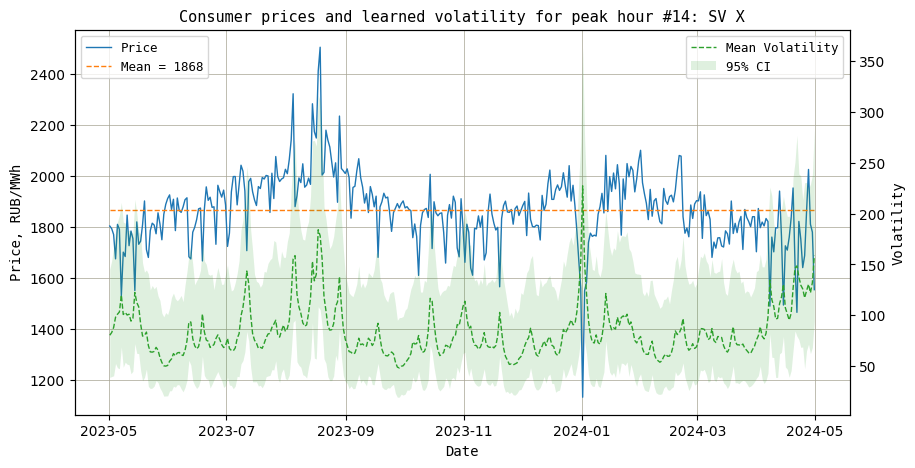

In [69]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(price_temp_data_peak_eur.index, price_temp_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Price')
ax.hlines(price_temp_data_peak_eur['CONSUMER_PRICE'].mean(), xmin=price_temp_data_peak_eur.index.min(), xmax=price_temp_data_peak_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {price_temp_data_peak_eur['CONSUMER_PRICE'].mean():.0f}")
ax.set_xlabel('Date', size=10, family='monospace')
ax.set_ylabel('Price, RUB/MWh', size=10, family='monospace')
ax.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
ax.grid(lw=0.5, color='xkcd:cement')
ax2 = ax.twinx()
ax2.plot(price_temp_data_peak_eur.index, vol_sv_x_peak_eur.mean(axis=0), color='C2', lw=1, ls='--', label='Mean Volatility')
ax2.fill_between(price_temp_data_peak_eur.index, np.percentile(vol_sv_x_peak_eur, [2.5, 97.5], axis=0)[0], np.percentile(vol_sv_x_peak_eur, [2.5, 97.5], axis=0)[1], color='C2', lw=0, alpha=0.15, label='95% CI')
ax2.set_ylabel('Volatility', size=10, family='monospace')
ax2.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
ax.set_title(f'Consumer prices and learned volatility for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace');

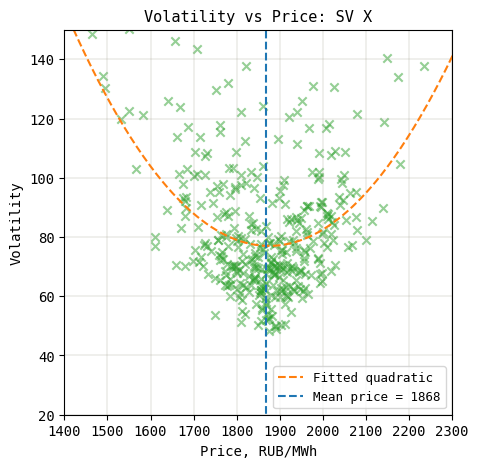

In [70]:
plt.figure(figsize=(5, 5))
fitted_quadratic = np.poly1d(np.polyfit(price_temp_data_peak_eur['CONSUMER_PRICE'], vol_sv_x_peak_eur.mean(axis=0), deg=2))
x = np.linspace(price_temp_data_peak_eur['CONSUMER_PRICE'].min(), price_temp_data_peak_eur['CONSUMER_PRICE'].max(), price_temp_data_peak_eur['CONSUMER_PRICE'].shape[0])
plt.scatter(price_temp_data_peak_eur['CONSUMER_PRICE'], vol_sv_x_peak_eur.mean(axis=0), color='C2', marker='x', alpha=0.5)
plt.plot(x, fitted_quadratic(x), color='C1', ls='--', label='Fitted quadratic')
plt.vlines(price_temp_data_peak_eur['CONSUMER_PRICE'].mean(), ymin=0, ymax=350, color='C0', ls='--', label=f"Mean price = {price_temp_data_peak_eur['CONSUMER_PRICE'].mean():.0f}")
plt.xlabel('Price, RUB/MWh', size=10, family='monospace')
plt.ylabel('Volatility', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xlim([1400, 2300])
plt.ylim([20, 150])
plt.title(f'Volatility vs Price: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='lower right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

As with SV Baseline, we can clearly see that volatility _does_ depend on consumer price, and our **SV X** model discovered this relation.

Again, as with SV Baseline, we can see a rather V-shaped dependency: the volatility tends to increase for the prices higher and lower than the mean price, while it's minimal around the mean price.

##### <a id="eval-sv-x"></a>3.5. Goodness-of-fit

In [71]:
# MAE for mean predictions over all draws
mae_sv_x = mean_absolute_error(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean)
print(f'{mae_sv_x = :.2f}')
print(f'{1 - mae_sv_x / mae_sv_base = :.2%}')

mae_sv_x = 85.23
1 - mae_sv_x / mae_sv_base = 14.06%


In [72]:
# RMSE for mean predictions over all draws
rmse_sv_x = root_mean_squared_error(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean)
print(f'{rmse_sv_x = :.2f}')
print(f'{1 - rmse_sv_x / rmse_sv_base = :.2%}')

rmse_sv_x = 117.91
1 - rmse_sv_x / rmse_sv_base = 13.96%


Let's check the correlation between mean predicted and actual prices.

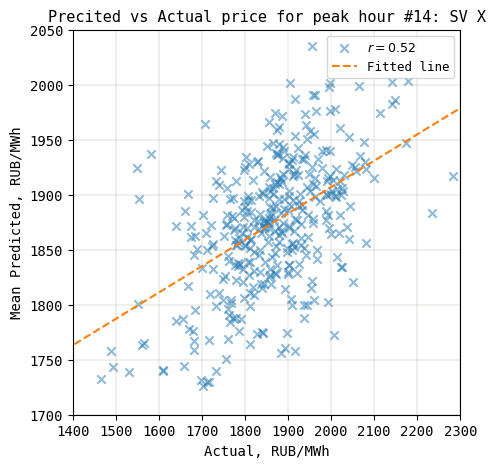

In [73]:
r = np.corrcoef(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean)[0, 1]
fitted_line = np.poly1d(np.polyfit(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean, deg=1))
x = np.linspace(price_temp_data_peak_eur['CONSUMER_PRICE'].min(), price_temp_data_peak_eur['CONSUMER_PRICE'].max(), price_temp_data_peak_eur['CONSUMER_PRICE'].shape[0])
plt.figure(figsize=(5, 5))
plt.scatter(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean, color='C0', marker='x', alpha=0.5, label=f'$r = {r:.2f}$')
plt.plot(x, fitted_line(x), color='C1', ls='--', label='Fitted line')
plt.xlabel('Actual, RUB/MWh', size=10, family='monospace')
plt.ylabel('Mean Predicted, RUB/MWh', size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.xlim([1400, 2300])
plt.ylim([1700, 2050])
plt.title(f'Precited vs Actual price for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

This time the correlation is much stronger, as compared to the SV Baseline model.

We should also check the distribution of residuals, probability plot (similar to Q-Q plot), and residuals vs mean predicted prices.

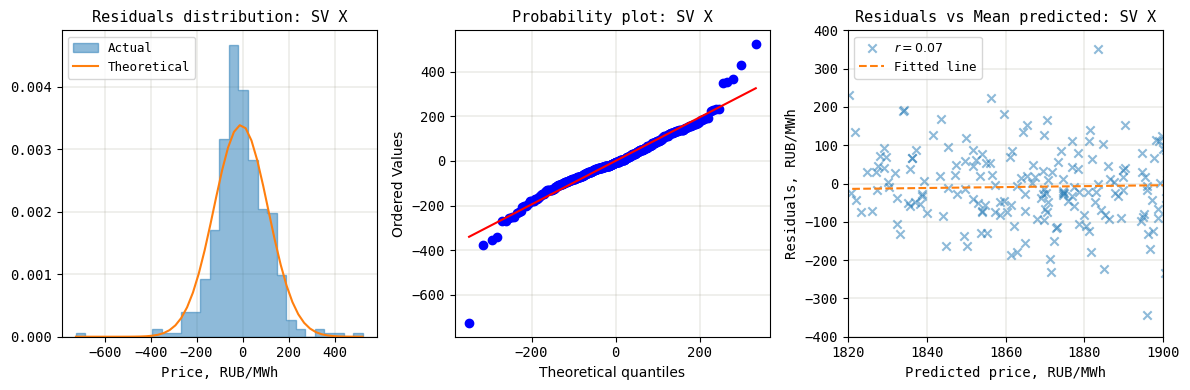

In [75]:
residuals_sv_x = price_data_peak_eur['CONSUMER_PRICE'] - predict_sv_x_peak_eur_mean
x = np.linspace(residuals_sv_x.min(), residuals_sv_x.max())
residuals_sv_x_theor = norm(residuals_sv_x.mean(), residuals_sv_x.std(ddof=1))
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(residuals_sv_x, bins=30, density=True, histtype='stepfilled', color='C0', edgecolor='C0', alpha=0.5, label='Actual')
plt.plot(x, residuals_sv_x_theor.pdf(x), color='C1', label='Theoretical')
plt.xlabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Residuals distribution: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.subplot(1, 3, 2)
probplot(residuals_sv_x, dist=residuals_sv_x_theor, plot=plt)
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Probability plot: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.subplot(1, 3, 3)
r = np.corrcoef(residuals_sv_x, predict_sv_x_peak_eur_mean)[0, 1]
fitted_line = np.poly1d(np.polyfit(predict_sv_x_peak_eur_mean, residuals_sv_x, deg=1))
x = np.linspace(predict_sv_x_peak_eur_mean.min(), predict_sv_x_peak_eur_mean.max(), predict_sv_x_peak_eur_mean.shape[0])
plt.scatter(predict_sv_x_peak_eur_mean, residuals_sv_x, color='C0', marker='x', alpha=0.5, label=f'$r = {r:.2f}$')
plt.plot(x, fitted_line(x), color='C1', ls='--', label='Fitted line')
plt.xlabel('Predicted price, RUB/MWh', size=10, family='monospace')
plt.ylabel('Residuals, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xlim([1820, 1900])
plt.ylim([-400, 400])
plt.title(f'Residuals vs Mean predicted: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.tight_layout();

Residuals look to be distributed more or less normally. Also they look rather homoscedastic w.r.t. predictions, which means that the model is rather acceptable.

**Overall, the SV X model is a better fit for our price data with the air temperature, day of the week, and lagged price as exogenous regressors, as compared to the SV Baseline model.**

[Back](#toc)

---
##### <a id="cross-val"></a>4. Cross-validation

We have trained and tested our models on the same fixed year-long time frame. There is a common practice to train and test models on different portions of the whole data to generate the distribution of metric(s) and ensure model robustness. This process is known as cross-validation: all data is divided into a number of non-intersecting subsets of samples (folds) some of which are used for training and the rest for testing. For data with i.i.d. samples, i.e. when the samples are independent and thus the order of samples is not important, the order of folds is also not important. This is not the case for time series data, where training folds must not be precede the testing folds, otherwise the target leakage will occur and the model cannot be trusted.


##### <a id="cross-val-strat"></a>4.1. Strategy

Cross-validation setup.

Models:
1) SV Baseline + Peak hour + Price zone 1 (European)
2) SV Baseline + Peak hour + Price zone 2 (Siberian)
3) SV Baseline + Off-peak hour + Price zone 1
4) SV Baseline + Off-peak hour + Price zone 2
5) SV X + Peak hour + Price zone 1
6) SV X + Peak hour + Price zone 2
7) SV X + Off-peak hour + Price zone 1
8) SV X + Off-peak hour + Price zone 2

Time frame: 23.06.2014 -- 30.04.2024 (3600 days), roughly 10 years from now.

Cross-validation strategy:
1) Choose the start date;
2) Train for 360 days (approx. 1 year train fold) from the start date;
3) Predict 90 days (approx. 3 months = 1 quarter test fold) ahead using the most recent log volatility obtained during training (90 points);
4) Move the date sliding window (update the start date) and repeat from 2 until all folds are done.

The number of date sliding windows $\displaystyle N_{w} = \frac{3600 - 30 \times 12}{30 \times 3} = 36$.

##### <a id="cross-val-sv-base"></a>4.2. SV Baseline

Load price data for the whole time frame and both price zones.

In [76]:
# # We need to explicitly specify the column names to correctly parse the xml
# price_data = pd.read_xml(f'https://www.atsenergo.ru/market/stats.xml?period=0&date1=20140623&date2=20240430&type=graph',
#                     names=['ROW_ID',
#                             'DAT',
#                             'PRICE_ZONE_CODE',
#                             'CONSUMER_VOLUME',
#                             'CONSUMER_PRICE',
#                             'CONSUMER_RD_VOLUME',
#                             'CONSUMER_SPOT_VOLUME',
#                             'CONSUMER_PROVIDE_RD',
#                             'CONSUMER_MAX_PRICE',
#                             'CONSUMER_MIN_PRICE',
#                             'SUPPLIER_VOLUME',
#                             'SUPPLIER_PRICE',
#                             'SUPPLIER_RD_VOLUME',
#                             'SUPPLIER_SPOT_VOLUME',
#                             'SUPPLIER_PROVIDE_RD',
#                             'SUPPLIER_MAX_PRICE',
#                             'SUPPLIER_MIN_PRICE',
#                             'HOUR'],
#                     xpath='//row',
#                     parse_dates=['DAT'])
# # Make datetime
# price_data = price_data.set_index(pd.to_datetime(price_data['DAT'].astype(str) + 'T' + price_data['HOUR'].astype(str) + ':00:00', dayfirst=True, errors='coerce'))
# price_data.index.name ='Datetime'
# # We can now drop all unnecessary columns to reduce the dataframe
# price_data = price_data.drop(columns=['ROW_ID',
#                         'DAT',
#                         'CONSUMER_VOLUME',
#                         'CONSUMER_RD_VOLUME',
#                         'CONSUMER_SPOT_VOLUME',
#                         'CONSUMER_PROVIDE_RD',
#                         'CONSUMER_MAX_PRICE',
#                         'CONSUMER_MIN_PRICE',
#                         'SUPPLIER_VOLUME',
#                         'SUPPLIER_PRICE',
#                         'SUPPLIER_RD_VOLUME',
#                         'SUPPLIER_SPOT_VOLUME',
#                         'SUPPLIER_PROVIDE_RD',
#                         'SUPPLIER_MAX_PRICE',
#                         'SUPPLIER_MIN_PRICE']).dropna()
# price_data = price_data.loc[~price_data.index.isna()].sort_index()
# price_data['Weekday'] = price_data.index.day_of_week
# price_data.to_csv('./data/price_data_20140623_20240430.csv')

In [77]:
price_data = pd.read_csv('./data/price_data_20140623_20240430.zip', index_col='Datetime', parse_dates=['Datetime'])

In [78]:
price_data.shape

(172800, 4)

In [79]:
price_data.head(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
Datetime,,,,
2014-06-23 00:00:00,1,1147.08,0,0
2014-06-23 00:00:00,2,685.81,0,0
2014-06-23 01:00:00,2,684.27,1,0
2014-06-23 01:00:00,1,1037.39,1,0


In [80]:
price_data.tail(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
Datetime,,,,
2024-04-30 22:00:00,2,1465.38,22,1
2024-04-30 22:00:00,1,1442.53,22,1
2024-04-30 23:00:00,2,1439.88,23,1
2024-04-30 23:00:00,1,1327.94,23,1


In [81]:
price_data.describe()

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
count,172800.000000,172800.000000,172800.000000,172800.000000
mean,1.500000,1128.835519,11.500000,2.998611
std,0.500001,311.825787,6.922207,2.000352
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,901.610000,5.750000,1.000000
50%,1.500000,1061.570000,11.500000,3.000000
75%,2.000000,1355.850000,17.250000,5.000000
max,2.000000,2504.960000,23.000000,6.000000


In [82]:
# Price zone 1 (European)
price_data_eur = price_data[price_data['PRICE_ZONE_CODE'] == 1]
# Price zone 2 (Siberian)
price_data_sib = price_data[price_data['PRICE_ZONE_CODE'] == 2]

In [83]:
# Hour profiles
price_data_daily_agg_eur = price_data_eur.groupby('HOUR')['CONSUMER_PRICE'].mean()
price_data_daily_agg_sib = price_data_sib.groupby('HOUR')['CONSUMER_PRICE'].mean()

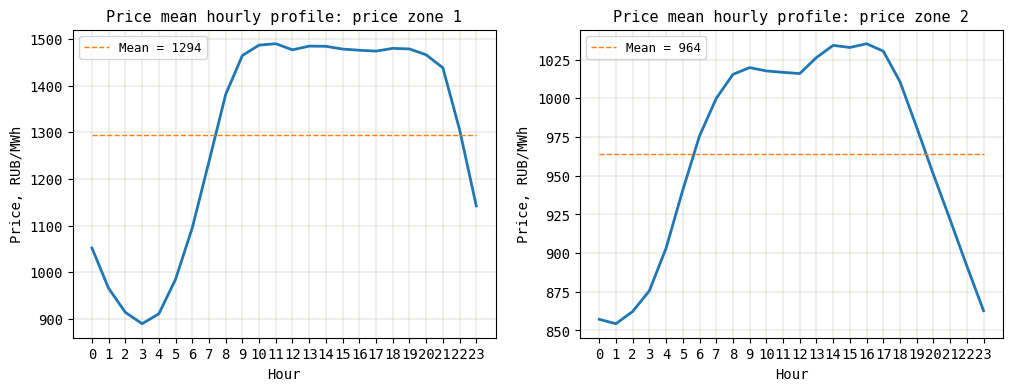

In [84]:
plt.figure(figsize=(12, 4))
for i, hour_profile in zip(range(1, 3), [price_data_daily_agg_eur, price_data_daily_agg_sib]):
    plt.subplot(1, 2, i)
    plt.plot(hour_profile.index, hour_profile, color='C0', lw=2)
    plt.hlines(hour_profile.mean(), xmin=hour_profile.index.min(), xmax=hour_profile.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {hour_profile.mean():.0f}")
    plt.xlabel('Hour', size=10, family='monospace')
    plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
    plt.xticks(hour_profile.index, size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.title(f'Price mean hourly profile: price zone {i}', size=11, family='monospace')
    plt.legend(prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement');

In [85]:
# Peak and off-peak hours
hour_max_eur = price_data_daily_agg_eur.idxmax()
hour_min_eur = price_data_daily_agg_eur.idxmin()
hour_max_sib = price_data_daily_agg_sib.idxmax()
hour_min_sib = price_data_daily_agg_sib.idxmin()
(hour_max_eur, hour_min_eur), (hour_max_sib, hour_min_sib)

((11, 3), (16, 1))

All cross-validation subsets for SV Baseline model.

In [86]:
price_data_peak_eur = price_data_eur[price_data_eur['HOUR'] == hour_max_eur]
price_data_offpeak_eur = price_data_eur[price_data_eur['HOUR'] == hour_min_eur]
price_data_peak_sib = price_data_sib[price_data_sib['HOUR'] == hour_max_sib]
price_data_offpeak_sib = price_data_sib[price_data_sib['HOUR'] == hour_min_sib]

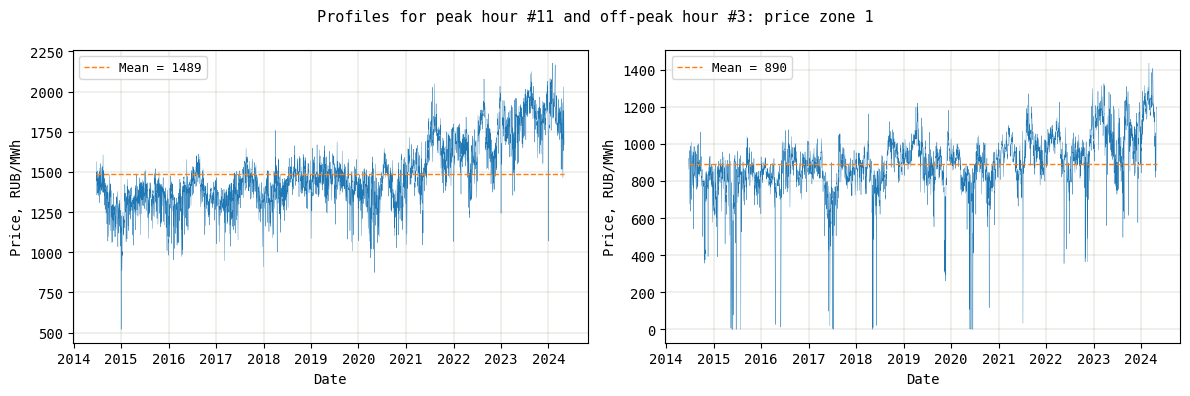

In [87]:
plt.figure(figsize=(12, 4))
for i, hour_profile in zip(range(1, 3), [price_data_peak_eur, price_data_offpeak_eur]):
    plt.subplot(1, 2, i)
    plt.plot(hour_profile.index, hour_profile['CONSUMER_PRICE'], color='C0', lw=0.25)
    plt.hlines(hour_profile['CONSUMER_PRICE'].mean(), xmin=hour_profile.index.min(), xmax=hour_profile.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {hour_profile['CONSUMER_PRICE'].mean():.0f}")
    plt.xlabel('Date', size=10, family='monospace')
    plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement');    
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Profiles for peak hour #{hour_max_eur} and off-peak hour #{hour_min_eur}: price zone 1', size=11, family='monospace')
plt.tight_layout();

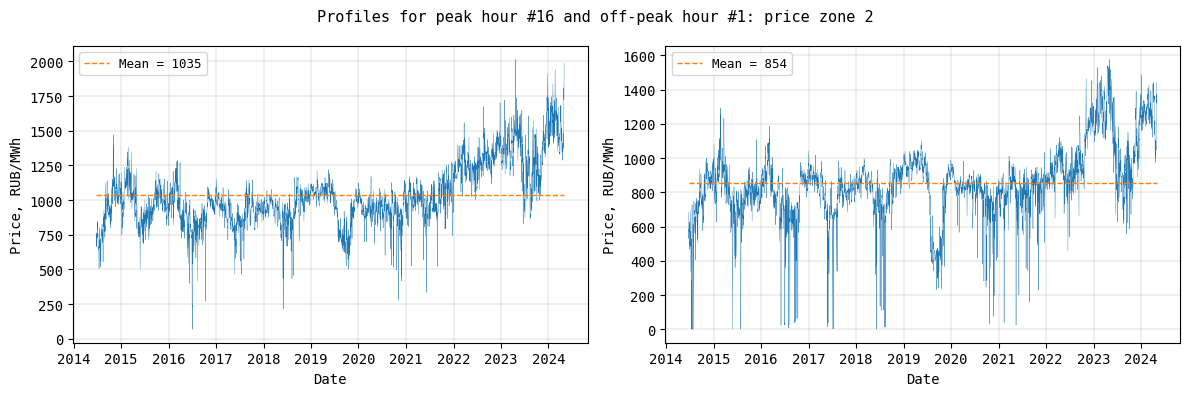

In [88]:
plt.figure(figsize=(12, 4))
for i, hour_profile in zip(range(1, 3), [price_data_peak_sib, price_data_offpeak_sib]):
    plt.subplot(1, 2, i)
    plt.plot(hour_profile.index, hour_profile['CONSUMER_PRICE'], color='C0', lw=0.25)
    plt.hlines(hour_profile['CONSUMER_PRICE'].mean(), xmin=hour_profile.index.min(), xmax=hour_profile.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {hour_profile['CONSUMER_PRICE'].mean():.0f}")
    plt.xlabel('Date', size=10, family='monospace')
    plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement');    
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Profiles for peak hour #{hour_max_sib} and off-peak hour #{hour_min_sib}: price zone 2', size=11, family='monospace')
plt.tight_layout();

All SV Baseline models to cross-validate.

In [89]:
with open('./models/sv_base_fit.stan', 'r') as fh:
  sv_base_code_fit = fh.read()
with open('./models/sv_base_predict.stan', 'r') as fh:
  sv_base_code_predict = fh.read()
num_samples = 1_000

In [90]:
# 1) SV Baseline + Peak hour + Price zone 1
model_sv_base_peak_eur = StanModel(kind='sv_base',
                                  name='SV Baseline + Peak hour + Price zone 1',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

In [91]:
# 2) SV Baseline + Peak hour + Price zone 2
model_sv_base_peak_sib = StanModel(kind='sv_base',
                                  name='SV Baseline + Peak hour + Price zone 2',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

In [92]:
# 3) SV Baseline + Off-peak hour + Price zone 1
model_sv_base_offpeak_eur = StanModel(kind='sv_base',
                                  name='SV Baseline + Off-peak hour + Price zone 1',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

In [93]:
# 4) SV Baseline + Off-peak hour + Price zone 2
model_sv_base_offpeak_sib = StanModel(kind='sv_base',
                                  name='SV Baseline + Off-peak hour + Price zone 2',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

Let's use scikit-learn's Time Series cross-validator to correctly split our data into train and test subsets.

In [94]:
n_windows = 36 # Number of sliding windows
ts_cv_sv_base = TimeSeriesSplit(n_splits=n_windows, max_train_size=30*12, test_size=30*3, gap=0)

In [95]:
print('Split # | Train fold                     | Test fold')
print('--------|--------------------------------|------------------------------')
# All 4 subsets have equal size, so get split indices from any of the four
for i, split in enumerate(ts_cv_sv_base.split(price_data_peak_eur)):
    train_start = price_data_peak_eur.iloc[split[0]].index.min().date()
    train_end = price_data_peak_eur.iloc[split[0]].index.max().date()
    test_start = price_data_peak_eur.iloc[split[1]].index.min().date()
    test_end = price_data_peak_eur.iloc[split[1]].index.max().date()
    print(f'{i + 1:>7} | {train_start} -- {train_end} ({(train_end - train_start).days + 1}) | {test_start} -- {test_end} ({(test_end - test_start).days + 1})')

Split # | Train fold                     | Test fold
--------|--------------------------------|------------------------------
      1 | 2014-06-23 -- 2015-06-17 (360) | 2015-06-18 -- 2015-09-15 (90)
      2 | 2014-09-21 -- 2015-09-15 (360) | 2015-09-16 -- 2015-12-14 (90)
      3 | 2014-12-20 -- 2015-12-14 (360) | 2015-12-15 -- 2016-03-13 (90)
      4 | 2015-03-20 -- 2016-03-13 (360) | 2016-03-14 -- 2016-06-11 (90)
      5 | 2015-06-18 -- 2016-06-11 (360) | 2016-06-12 -- 2016-09-09 (90)
      6 | 2015-09-16 -- 2016-09-09 (360) | 2016-09-10 -- 2016-12-08 (90)
      7 | 2015-12-15 -- 2016-12-08 (360) | 2016-12-09 -- 2017-03-08 (90)
      8 | 2016-03-14 -- 2017-03-08 (360) | 2017-03-09 -- 2017-06-06 (90)
      9 | 2016-06-12 -- 2017-06-06 (360) | 2017-06-07 -- 2017-09-04 (90)
     10 | 2016-09-10 -- 2017-09-04 (360) | 2017-09-05 -- 2017-12-03 (90)
     11 | 2016-12-09 -- 2017-12-03 (360) | 2017-12-04 -- 2018-03-03 (90)
     12 | 2017-03-09 -- 2018-03-03 (360) | 2018-03-04 -- 2018-06-01 (90

In [ ]:
%%capture
models = [model_sv_base_peak_eur, model_sv_base_peak_sib, model_sv_base_offpeak_eur, model_sv_base_offpeak_sib]
subsets = [price_data_peak_eur, price_data_peak_sib, price_data_offpeak_eur, price_data_offpeak_sib]
cv_results_sv_base_df = pd.DataFrame(columns=['model_kind', 'model_name', 'train_indices', 'test_indices', 'fit_time', 'score_time', 'test_mae', 'test_rmse'])
print('Running cross-validation...')
for model, subset in tqdm(zip(models, subsets)):
    print(f'Model: {model.name}')
    cv_result = cross_validate(model,
                                X=subset['CONSUMER_PRICE'],
                                y=subset['CONSUMER_PRICE'],
                                cv=ts_cv_sv_base,
                                scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                                return_indices=True,
                                n_jobs=4)
    cv_result_df = pd.concat([pd.Series(cv_result['indices']['train'], name='train_indices'),
                              pd.Series(cv_result['indices']['test'], name='test_indices'),
                              pd.Series(cv_result['fit_time'], name='fit_time'), 
                              pd.Series(cv_result['score_time'], name='score_time'), 
                              pd.Series(-cv_result['test_neg_mean_absolute_error'], name='test_mae'), 
                              pd.Series(-cv_result['test_neg_root_mean_squared_error'], name='test_rmse')], axis=1)
    cv_results_sv_base_df = pd.concat([cv_results_sv_base_df, 
                                       pd.concat([pd.Series([model.kind] * n_windows, name='model_kind'), 
                                       pd.Series([model.name] * n_windows, name='model_name'), 
                                       cv_result_df], axis=1)])
cv_results_sv_base_df = cv_results_sv_base_df.reset_index(drop=True)
print('Done!')

In [97]:
cv_results_sv_base_df

,model_kind,model_name,train_indices,test_indices,fit_time,score_time,test_mae,test_rmse
0,sv_base,SV Baseline + Peak hour + Price zone 1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",0.699812,0.336854,66.932230,82.187065
1,sv_base,SV Baseline + Peak hour + Price zone 1,"[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...","[450, 451, 452, 453, 454, 455, 456, 457, 458, ...",0.708981,0.328631,91.498069,102.352921
2,sv_base,SV Baseline + Peak hour + Price zone 1,"[180, 181, 182, 183, 184, 185, 186, 187, 188, ...","[540, 541, 542, 543, 544, 545, 546, 547, 548, ...",11.306415,0.241281,98.059416,131.124286
3,sv_base,SV Baseline + Peak hour + Price zone 1,"[270, 271, 272, 273, 274, 275, 276, 277, 278, ...","[630, 631, 632, 633, 634, 635, 636, 637, 638, ...",6.881462,0.236985,90.657318,116.004756
4,sv_base,SV Baseline + Peak hour + Price zone 1,"[360, 361, 362, 363, 364, 365, 366, 367, 368, ...","[720, 721, 722, 723, 724, 725, 726, 727, 728, ...",0.701130,0.227564,144.874059,158.346917
...,...,...,...,...,...,...,...,...
139,sv_base,SV Baseline + Off-peak hour + Price zone 2,"[2790, 2791, 2792, 2793, 2794, 2795, 2796, 279...","[3150, 3151, 3152, 3153, 3154, 3155, 3156, 315...",0.593011,0.214326,303.764088,326.017876
140,sv_base,SV Baseline + Off-peak hour + Price zone 2,"[2880, 2881, 2882, 2883, 2884, 2885, 2886, 288...","[3240, 3241, 3242, 3243, 3244, 3245, 3246, 324...",0.777699,0.216780,175.065520,206.851707
141,sv_base,SV Baseline + Off-peak hour + Price zone 2,"[2970, 2971, 2972, 2973, 2974, 2975, 2976, 297...","[3330, 3331, 3332, 3333, 3334, 3335, 3336, 333...",8.670185,0.216543,261.340821,287.419361
142,sv_base,SV Baseline + Off-peak hour + Price zone 2,"[3060, 3061, 3062, 3063, 3064, 3065, 3066, 306...","[3420, 3421, 3422, 3423, 3424, 3425, 3426, 342...",11.944015,0.184252,121.891326,137.366055


In [98]:
# Mean MAE by model
mae_sv_base_cross = cv_results_sv_base_df.groupby('model_name')['test_mae']
mae_sv_base_cross.mean().sort_values()

model_name
SV Baseline + Off-peak hour + Price zone 1    104.422811
SV Baseline + Peak hour + Price zone 1        105.385055
SV Baseline + Peak hour + Price zone 2        119.140971
SV Baseline + Off-peak hour + Price zone 2    134.863451
Name: test_mae, dtype: float64

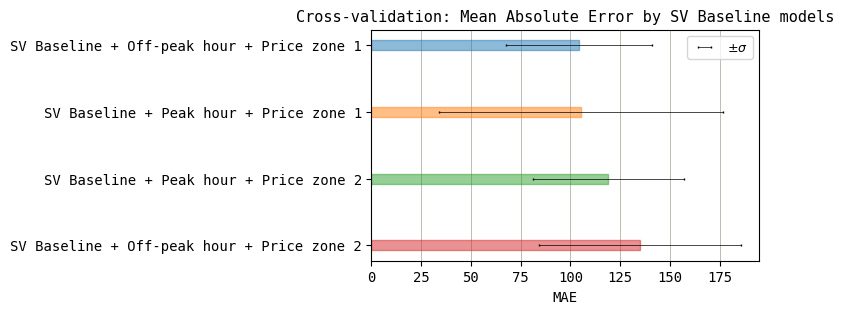

In [99]:
plt.figure(figsize=(5, 3))
bars = plt.barh(range(mae_sv_base_cross.mean().shape[0]), mae_sv_base_cross.mean().sort_values(), xerr=mae_sv_base_cross.std(ddof=1), height=0.15, align='center', alpha=0.5, error_kw={'lw': 0.5, 'capsize': 1, 'label': '$\pm \sigma$'})
plt.gca().invert_yaxis()
plt.xlabel('MAE', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(range(mae_sv_base_cross.mean().shape[0]), mae_sv_base_cross.mean().sort_values().index, size=10, family='monospace')
plt.grid(axis='x', lw=0.5, color='xkcd:cement')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
    bars[i].set_color(f'C{i}')
plt.gca().set_axisbelow(True)
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.title('Cross-validation: Mean Absolute Error by SV Baseline models', size=11, family='monospace');

In [100]:
# Mean RMSE by model
rmse_sv_base_cross = cv_results_sv_base_df.groupby('model_name')['test_rmse']
rmse_sv_base_cross.mean().sort_values()

model_name
SV Baseline + Peak hour + Price zone 1        130.526412
SV Baseline + Off-peak hour + Price zone 1    137.501447
SV Baseline + Peak hour + Price zone 2        146.445320
SV Baseline + Off-peak hour + Price zone 2    168.305299
Name: test_rmse, dtype: float64

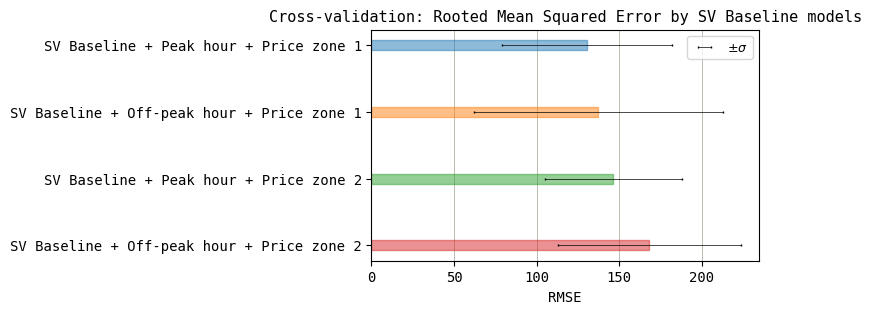

In [101]:
plt.figure(figsize=(5, 3))
bars = plt.barh(range(rmse_sv_base_cross.mean().shape[0]), rmse_sv_base_cross.mean().sort_values(), xerr=rmse_sv_base_cross.std(ddof=1), height=0.15, align='center', alpha=0.5, error_kw={'lw': 0.5, 'capsize': 1, 'label': '$\pm \sigma$'})
plt.gca().invert_yaxis()
plt.xlabel('RMSE', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(range(rmse_sv_base_cross.mean().shape[0]), rmse_sv_base_cross.mean().sort_values().index, size=10, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(axis='x', lw=0.5, color='xkcd:cement')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
    bars[i].set_color(f'C{i}')
plt.gca().set_axisbelow(True)
plt.title('Cross-validation: Rooted Mean Squared Error by SV Baseline models', size=11, family='monospace');

Both metrics show that on average:
- SV Baseline models for Price zone 1 (European) have higher quality than for Price zone 2 (Siberian);
- the best model is for Price zone 1 for Peak hour;
- the worst model is for Price zone 2 for Off-peak hour.

##### <a id="cross-val-sv-x"></a>4.3. SV X

Load air temperature data for the whole time frame and both price zones.

In [102]:
# Price zone 1: Moscow
temp_data_eur = pd.read_csv(f'./data/UUEE.23.06.2014.30.04.2024.1.0.0.ru.utf8.00000000.zip', 
                        sep=';', 
                        encoding='utf-8',
                        skiprows=7, 
                        index_col=0, 
                        dayfirst=True, 
                        usecols=[0, 1], 
                        names=['Datetime', 'Temperature'], 
                        parse_dates=True).dropna().sort_index()

In [103]:
temp_data_eur

,Temperature
Datetime,
2014-06-23 00:00:00,8.0
2014-06-23 00:30:00,9.0
2014-06-23 01:00:00,8.0
2014-06-23 01:30:00,10.0
2014-06-23 02:00:00,12.0
...,...
2024-04-30 21:30:00,18.0
2024-04-30 22:00:00,19.0
2024-04-30 22:30:00,19.0


In [104]:
# Price zone 2: Novosibirsk
temp_data_sib = pd.read_csv(f'./data/UNNT.23.06.2014.30.04.2024.1.0.0.ru.utf8.00000000.zip', 
                        sep=';', 
                        encoding='utf-8',
                        skiprows=7, 
                        index_col=0, 
                        dayfirst=True, 
                        usecols=[0, 1], 
                        names=['Datetime', 'Temperature'], 
                        parse_dates=True).dropna().sort_index()
# Don't forget to convert local Novosibirsk time to Moscow time, since all price data is in Moscow time
temp_data_sib.index = temp_data_sib.index - pd.Timedelta(hours=4)

In [105]:
temp_data_sib

,Temperature
Datetime,
2014-06-22 20:00:00,21.0
2014-06-22 20:30:00,20.0
2014-06-22 21:00:00,19.0
2014-06-22 21:30:00,18.0
2014-06-22 22:00:00,17.0
...,...
2024-04-30 17:30:00,3.0
2024-04-30 18:00:00,2.0
2024-04-30 18:30:00,1.0


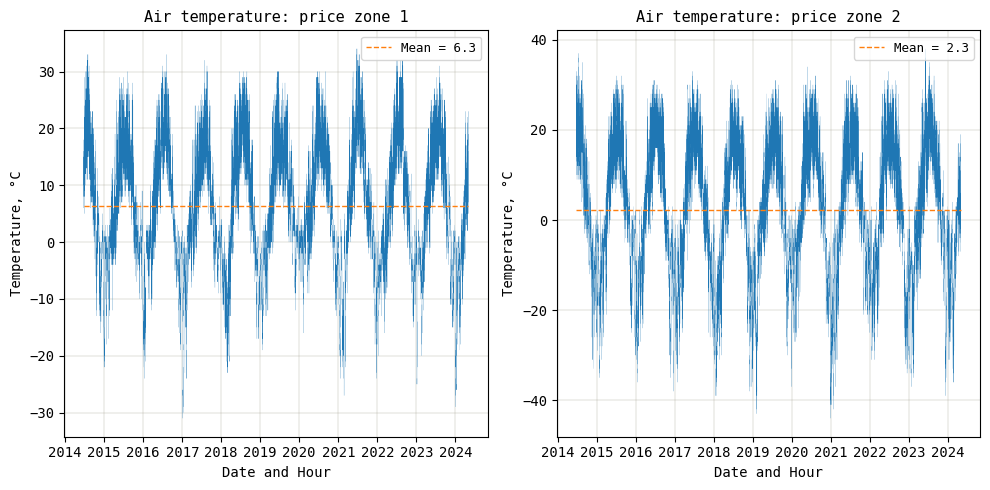

In [106]:
plt.figure(figsize=(10, 5))
for i, temp_history in zip(range(1, 3), [temp_data_eur, temp_data_sib]):
    plt.subplot(1, 2, i)
    plt.plot(temp_history.index, temp_history['Temperature'], color='C0', lw=0.1)
    plt.hlines(temp_history['Temperature'].mean(), xmin=temp_history.index.min(), xmax=temp_history.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {temp_history['Temperature'].mean():.1f}")
    plt.xlabel('Date and Hour', size=10, family='monospace')
    plt.ylabel('Temperature, °C', size=10, family='monospace')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.title(f'Air temperature: price zone {i}', size=11, family='monospace')
    plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement')
plt.tight_layout();

In [107]:
# Join consumer price and air temperature data
price_temp_data_peak_eur = pd.merge(price_data_peak_eur, temp_data_eur, on='Datetime')
price_temp_data_offpeak_eur = pd.merge(price_data_offpeak_eur, temp_data_eur, on='Datetime')
price_temp_data_peak_sib = pd.merge(price_data_peak_sib, temp_data_sib, on='Datetime')
price_temp_data_offpeak_sib = pd.merge(price_data_offpeak_sib, temp_data_sib, on='Datetime')

All SV X models to cross-validate.

In [108]:
with open('./models/sv_x_fit.stan', 'r') as fh:
  sv_x_code_fit = fh.read()
with open('./models/sv_x_predict.stan', 'r') as fh:
  sv_x_code_predict = fh.read()
num_samples = 1_000

In [109]:
# 5) SV X + Peak hour + Price zone 1
model_sv_x_peak_eur = StanModel(kind='sv_x',
                                  name='SV X + Peak hour + Price zone 1',
                                  stan_code_fit=sv_x_code_fit,
                                  stan_code_predict=sv_x_code_predict, 
                                  num_samples=num_samples)

In [110]:
# 6) SV X + Peak hour + Price zone 2
model_sv_x_peak_sib = StanModel(kind='sv_x',
                                  name='SV X + Peak hour + Price zone 2',
                                  stan_code_fit=sv_x_code_fit,
                                  stan_code_predict=sv_x_code_predict, 
                                  num_samples=num_samples)

In [111]:
# 7) SV X + Off-peak hour + Price zone 1
model_sv_x_offpeak_eur = StanModel(kind='sv_x',
                                  name='SV X + Off-peak hour + Price zone 1',
                                  stan_code_fit=sv_x_code_fit,
                                  stan_code_predict=sv_x_code_predict, 
                                  num_samples=num_samples)

In [112]:
# 8) SV X + Off-peak hour + Price zone 2
model_sv_x_offpeak_sib = StanModel(kind='sv_x',
                                  name='SV X + Off-peak hour + Price zone 2',
                                  stan_code_fit=sv_x_code_fit,
                                  stan_code_predict=sv_x_code_predict, 
                                  num_samples=num_samples)

In [113]:
n_windows = 36 # Number of sliding windows
ts_cv_sv_x = TimeSeriesSplit(n_splits=n_windows, max_train_size=30*12, test_size=30*3, gap=0)

In [114]:
print('Split # | Train fold                     | Test fold')
print('--------|--------------------------------|------------------------------')
# Due to air temperature having missing data, the 4 subsets are not strictly equal, but anyway have around 3600 days each
# So get split indices from any of the four
for i, split in enumerate(ts_cv_sv_x.split(price_temp_data_peak_eur)):
    train_start = price_temp_data_peak_eur.iloc[split[0]].index.min().date()
    train_end = price_temp_data_peak_eur.iloc[split[0]].index.max().date()
    test_start = price_temp_data_peak_eur.iloc[split[1]].index.min().date()
    test_end = price_temp_data_peak_eur.iloc[split[1]].index.max().date()
    print(f'{i + 1:>7} | {train_start} -- {train_end} ({(train_end - train_start).days + 1}) | {test_start} -- {test_end} ({(test_end - test_start).days + 1})')

Split # | Train fold                     | Test fold
--------|--------------------------------|------------------------------
      1 | 2014-06-23 -- 2015-06-09 (352) | 2015-06-10 -- 2015-09-10 (93)
      2 | 2014-09-13 -- 2015-09-10 (363) | 2015-09-11 -- 2015-12-10 (91)
      3 | 2014-12-12 -- 2015-12-10 (364) | 2015-12-11 -- 2016-03-09 (90)
      4 | 2015-03-12 -- 2016-03-09 (364) | 2016-03-10 -- 2016-06-08 (91)
      5 | 2015-06-10 -- 2016-06-08 (365) | 2016-06-09 -- 2016-09-07 (91)
      6 | 2015-09-11 -- 2016-09-07 (363) | 2016-09-08 -- 2016-12-06 (90)
      7 | 2015-12-11 -- 2016-12-06 (362) | 2016-12-07 -- 2017-03-06 (90)
      8 | 2016-03-10 -- 2017-03-06 (362) | 2017-03-07 -- 2017-06-04 (90)
      9 | 2016-06-09 -- 2017-06-04 (361) | 2017-06-06 -- 2017-09-03 (90)
     10 | 2016-09-08 -- 2017-09-03 (361) | 2017-09-04 -- 2017-12-02 (90)
     11 | 2016-12-07 -- 2017-12-02 (361) | 2017-12-03 -- 2018-03-02 (90)
     12 | 2017-03-07 -- 2018-03-02 (361) | 2018-03-03 -- 2018-05-31 (90

In [ ]:
%%capture
models = [model_sv_x_peak_eur, model_sv_x_peak_sib, model_sv_x_offpeak_eur, model_sv_x_offpeak_sib]
subsets = [price_temp_data_peak_eur, price_temp_data_peak_sib, price_temp_data_offpeak_eur, price_temp_data_offpeak_sib]
cv_results_sv_x_df = pd.DataFrame(columns=['model_kind', 'model_name', 'train_indices', 'test_indices', 'fit_time', 'score_time', 'test_mae', 'test_rmse'])
print('Running cross-validation...')
for model, subset in tqdm(zip(models, subsets)):
    print(f'Model: {model.name}')
    cv_result = cross_validate(model,
                                X=subset[['Temperature', 'Weekday']],
                                y=subset['CONSUMER_PRICE'],
                                cv=ts_cv_sv_x,
                                scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                                return_indices=True,
                                n_jobs=4)
    cv_result_df = pd.concat([pd.Series(cv_result['indices']['train'], name='train_indices'),
                              pd.Series(cv_result['indices']['test'], name='test_indices'),
                              pd.Series(cv_result['fit_time'], name='fit_time'), 
                              pd.Series(cv_result['score_time'], name='score_time'), 
                              pd.Series(-cv_result['test_neg_mean_absolute_error'], name='test_mae'), 
                              pd.Series(-cv_result['test_neg_root_mean_squared_error'], name='test_rmse')], axis=1)
    cv_results_sv_x_df = pd.concat([cv_results_sv_x_df, 
                                    pd.concat([pd.Series([model.kind] * n_windows, name='model_kind'), 
                                               pd.Series([model.name] * n_windows, name='model_name'), 
                                               cv_result_df], axis=1)])
cv_results_sv_x_df = cv_results_sv_x_df.reset_index(drop=True)
print('Done!')

In [116]:
cv_results_sv_x_df

,model_kind,model_name,train_indices,test_indices,fit_time,score_time,test_mae,test_rmse
0,sv_x,SV X + Peak hour + Price zone 1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[352, 353, 354, 355, 356, 357, 358, 359, 360, ...",59.982939,0.205332,59.323989,78.198409
1,sv_x,SV X + Peak hour + Price zone 1,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...","[442, 443, 444, 445, 446, 447, 448, 449, 450, ...",62.125227,0.213007,78.687178,91.355468
2,sv_x,SV X + Peak hour + Price zone 1,"[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[532, 533, 534, 535, 536, 537, 538, 539, 540, ...",67.531381,0.208956,103.487499,133.646347
3,sv_x,SV X + Peak hour + Price zone 1,"[262, 263, 264, 265, 266, 267, 268, 269, 270, ...","[622, 623, 624, 625, 626, 627, 628, 629, 630, ...",56.205181,0.226946,77.415557,107.571970
4,sv_x,SV X + Peak hour + Price zone 1,"[352, 353, 354, 355, 356, 357, 358, 359, 360, ...","[712, 713, 714, 715, 716, 717, 718, 719, 720, ...",66.795852,0.218768,107.451251,126.140198
...,...,...,...,...,...,...,...,...
139,sv_x,SV X + Off-peak hour + Price zone 2,"[2760, 2761, 2762, 2763, 2764, 2765, 2766, 276...","[3120, 3121, 3122, 3123, 3124, 3125, 3126, 312...",44.314485,0.646686,247.346148,280.565937
140,sv_x,SV X + Off-peak hour + Price zone 2,"[2850, 2851, 2852, 2853, 2854, 2855, 2856, 285...","[3210, 3211, 3212, 3213, 3214, 3215, 3216, 321...",61.488181,0.217517,171.590954,204.755421
141,sv_x,SV X + Off-peak hour + Price zone 2,"[2940, 2941, 2942, 2943, 2944, 2945, 2946, 294...","[3300, 3301, 3302, 3303, 3304, 3305, 3306, 330...",48.110468,0.193196,182.417883,215.258129
142,sv_x,SV X + Off-peak hour + Price zone 2,"[3030, 3031, 3032, 3033, 3034, 3035, 3036, 303...","[3390, 3391, 3392, 3393, 3394, 3395, 3396, 339...",50.155917,0.221359,97.460099,120.374840


In [117]:
# Mean MAE by model
mae_sv_x_cross = cv_results_sv_x_df.groupby('model_name')['test_mae']
mae_sv_x_cross.mean().sort_values()

model_name
SV X + Off-peak hour + Price zone 1     93.920306
SV X + Peak hour + Price zone 1         99.451586
SV X + Peak hour + Price zone 2        115.563463
SV X + Off-peak hour + Price zone 2    118.180067
Name: test_mae, dtype: float64

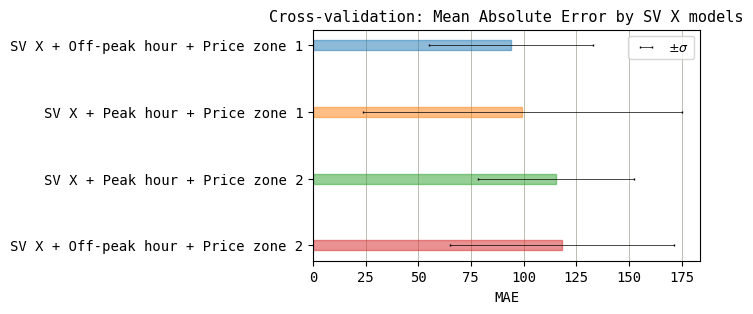

In [118]:
plt.figure(figsize=(5, 3))
bars = plt.barh(range(mae_sv_x_cross.mean().shape[0]), mae_sv_x_cross.mean().sort_values(), xerr=mae_sv_x_cross.std(ddof=1), height=0.15, align='center', alpha=0.5, error_kw={'lw': 0.5, 'capsize': 1, 'label': '$\pm \sigma$'})
plt.gca().invert_yaxis()
plt.xlabel('MAE', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(range(mae_sv_x_cross.mean().shape[0]), mae_sv_x_cross.mean().sort_values().index, size=10, family='monospace')
plt.grid(axis='x', lw=0.5, color='xkcd:cement')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
    bars[i].set_color(f'C{i}')
plt.gca().set_axisbelow(True)
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.title('Cross-validation: Mean Absolute Error by SV X models', size=11, family='monospace');

In [119]:
# Mean RMSE by model
rmse_sv_x_cross = cv_results_sv_x_df.groupby('model_name')['test_rmse']
rmse_sv_x_cross.mean().sort_values()

model_name
SV X + Peak hour + Price zone 1        123.588498
SV X + Off-peak hour + Price zone 1    129.588961
SV X + Peak hour + Price zone 2        142.098038
SV X + Off-peak hour + Price zone 2    150.729970
Name: test_rmse, dtype: float64

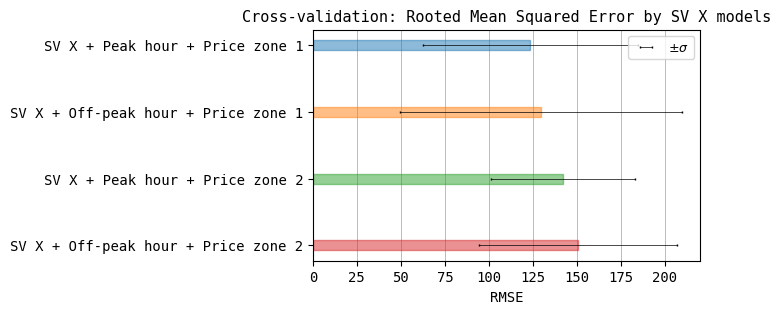

In [120]:
plt.figure(figsize=(5, 3))
bars = plt.barh(range(rmse_sv_x_cross.mean().shape[0]), rmse_sv_x_cross.mean().sort_values(), xerr=rmse_sv_x_cross.std(ddof=1), height=0.15, align='center', alpha=0.5, error_kw={'lw': 0.5, 'capsize': 1, 'label': '$\pm \sigma$'})
plt.gca().invert_yaxis()
plt.xlabel('RMSE', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(range(rmse_sv_x_cross.mean().shape[0]), rmse_sv_x_cross.mean().sort_values().index, size=10, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(axis='x', lw=0.5, color='xkcd:cement')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
    bars[i].set_color(f'C{i}')
plt.gca().set_axisbelow(True)
plt.title('Cross-validation: Rooted Mean Squared Error by SV X models', size=11, family='monospace');

As with SV Baseline model, both metrics for SV X model show that on average:
- models for Price zone 1 (European) have higher quality than for Price zone 2 (Siberian);
- the best model is for Price zone 1 for Peak hour;
- the worst model is for Price zone 2 for Off-peak hour.

##### <a id="cross-val-comparison"></a>4.4. Model Comparison

Let's compare the distributions of MAE and RMSE metrics obtained during cross-validation.

In [121]:
cv_results_sv_all_df = pd.concat([cv_results_sv_base_df, cv_results_sv_x_df], axis=0)
cv_results_sv_all_df

,model_kind,model_name,train_indices,test_indices,fit_time,score_time,test_mae,test_rmse
0,sv_base,SV Baseline + Peak hour + Price zone 1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",0.699812,0.336854,66.932230,82.187065
1,sv_base,SV Baseline + Peak hour + Price zone 1,"[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...","[450, 451, 452, 453, 454, 455, 456, 457, 458, ...",0.708981,0.328631,91.498069,102.352921
2,sv_base,SV Baseline + Peak hour + Price zone 1,"[180, 181, 182, 183, 184, 185, 186, 187, 188, ...","[540, 541, 542, 543, 544, 545, 546, 547, 548, ...",11.306415,0.241281,98.059416,131.124286
3,sv_base,SV Baseline + Peak hour + Price zone 1,"[270, 271, 272, 273, 274, 275, 276, 277, 278, ...","[630, 631, 632, 633, 634, 635, 636, 637, 638, ...",6.881462,0.236985,90.657318,116.004756
4,sv_base,SV Baseline + Peak hour + Price zone 1,"[360, 361, 362, 363, 364, 365, 366, 367, 368, ...","[720, 721, 722, 723, 724, 725, 726, 727, 728, ...",0.701130,0.227564,144.874059,158.346917
...,...,...,...,...,...,...,...,...
139,sv_x,SV X + Off-peak hour + Price zone 2,"[2760, 2761, 2762, 2763, 2764, 2765, 2766, 276...","[3120, 3121, 3122, 3123, 3124, 3125, 3126, 312...",44.314485,0.646686,247.346148,280.565937
140,sv_x,SV X + Off-peak hour + Price zone 2,"[2850, 2851, 2852, 2853, 2854, 2855, 2856, 285...","[3210, 3211, 3212, 3213, 3214, 3215, 3216, 321...",61.488181,0.217517,171.590954,204.755421
141,sv_x,SV X + Off-peak hour + Price zone 2,"[2940, 2941, 2942, 2943, 2944, 2945, 2946, 294...","[3300, 3301, 3302, 3303, 3304, 3305, 3306, 330...",48.110468,0.193196,182.417883,215.258129
142,sv_x,SV X + Off-peak hour + Price zone 2,"[3030, 3031, 3032, 3033, 3034, 3035, 3036, 303...","[3390, 3391, 3392, 3393, 3394, 3395, 3396, 339...",50.155917,0.221359,97.460099,120.374840


In [122]:
cv_results_peak_eur = cv_results_sv_all_df[cv_results_sv_all_df['model_name'].str.contains('\+ Peak hour \+ Price zone 1')]
cv_results_offpeak_eur = cv_results_sv_all_df[cv_results_sv_all_df['model_name'].str.contains('\+ Off-peak hour \+ Price zone 1')]
cv_results_peak_sib = cv_results_sv_all_df[cv_results_sv_all_df['model_name'].str.contains('\+ Peak hour \+ Price zone 2')]
cv_results_offpeak_sib = cv_results_sv_all_df[cv_results_sv_all_df['model_name'].str.contains('\+ Off-peak hour \+ Price zone 2')]

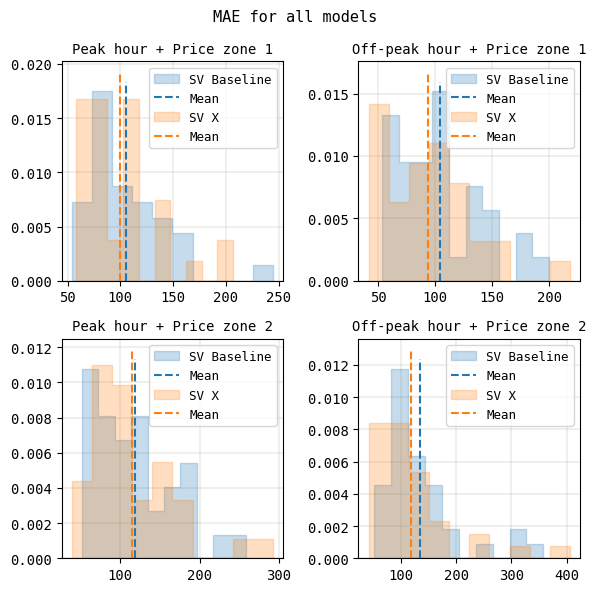

In [123]:
plt.figure(figsize=(6, 6))
for i, subset in zip(range(1, 5), [cv_results_peak_eur, cv_results_offpeak_eur, cv_results_peak_sib, cv_results_offpeak_sib]):
    plt.subplot(2, 2, i)
    plt.hist(subset[subset['model_kind'] == 'sv_base']['test_mae'], bins=10, density=True, histtype='stepfilled', color='C0', edgecolor='C0', alpha=0.25, label='SV Baseline')
    plt.vlines(subset[subset['model_kind'] == 'sv_base']['test_mae'].mean(), ymin=0, ymax=plt.ylim()[1], color='C0', ls='--', label='Mean')
    plt.hist(subset[subset['model_kind'] == 'sv_x']['test_mae'], bins=10, density=True, histtype='stepfilled', color='C1', edgecolor='C1', alpha=0.25, label='SV X')
    plt.vlines(subset[subset['model_kind'] == 'sv_x']['test_mae'].mean(), ymin=0, ymax=plt.ylim()[1], color='C1', ls='--', label='Mean')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
    plt.title(f"{' + '.join(subset['model_name'].unique()[0].split(' + ')[1:])}", size=10, family='monospace')
    plt.grid(lw=0.25, color='xkcd:cement')
    plt.gca().set_axisbelow(True)
plt.suptitle(f'MAE for all models', size=11, family='monospace')
plt.tight_layout();

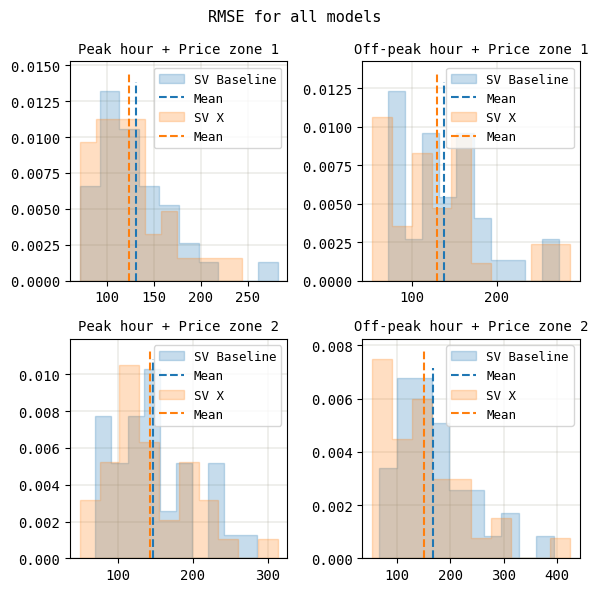

In [124]:
plt.figure(figsize=(6, 6))
for i, subset in zip(range(1, 5), [cv_results_peak_eur, cv_results_offpeak_eur, cv_results_peak_sib, cv_results_offpeak_sib]):
    plt.subplot(2, 2, i)
    plt.hist(subset[subset['model_kind'] == 'sv_base']['test_rmse'], bins=10, density=True, histtype='stepfilled', color='C0', edgecolor='C0', alpha=0.25, label='SV Baseline')
    plt.vlines(subset[subset['model_kind'] == 'sv_base']['test_rmse'].mean(), ymin=0, ymax=plt.ylim()[1], color='C0', ls='--', label='Mean')
    plt.hist(subset[subset['model_kind'] == 'sv_x']['test_rmse'], bins=10, density=True, histtype='stepfilled', color='C1', edgecolor='C1', alpha=0.25, label='SV X')
    plt.vlines(subset[subset['model_kind'] == 'sv_x']['test_rmse'].mean(), ymin=0, ymax=plt.ylim()[1], color='C1', ls='--', label='Mean')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
    plt.title(f"{' + '.join(subset['model_name'].unique()[0].split(' + ')[1:])}", size=10, family='monospace')
    plt.grid(lw=0.25, color='xkcd:cement')
    plt.gca().set_axisbelow(True)
plt.suptitle(f'RMSE for all models', size=11, family='monospace')
plt.tight_layout();

We should also check the statistical significance of the difference in the metrics. We will use a non-parametric one-tailed Mann-Whitney U test for two independent samples to see if the distributions of metrics for SV Baseline and SV X models are identical or have a shift between each other.

$\displaystyle \mathcal{H}_0: F_{X_1}(x) =  F_{X_2}(x)$ (distributed identically)

$\displaystyle \mathcal{H}_1: F_{X_1}(x) =  F_{X_2}(x + \Delta x)$ (distributed with positive shift $\Delta x$), where

$F_{X_1}(x)$ is the distribution of a given metric for SV Baseline model; $F_{X_2}(x)$ is the distribution of a given metric for SV X model

Statistic: Mann-Whitney's $U$

Null distribution: no assumption; generated empirically by permutation test; for large samples it can be approximated by $\mathcal N (\mu = \frac{n_1 n_2}{2}, \sigma^2 = \frac{n_1 n_2 (n_1 + n_2 + 1)}{12})$.

In [125]:
# Two independent samples one-tailed Mann-Whitney U test for MAE
alpha = 0.05
mwu_stats, mwu_pval = mannwhitneyu(cv_results_sv_base_df['test_mae'], cv_results_sv_x_df['test_mae'], alternative='greater')
print(f'{mwu_stats = :.0f}, {mwu_pval = :.4f}', end=', ')
print("SV Baseline's MAE is greater than SV X's MAE (shifted to the right = worse)") if mwu_pval < alpha else print('SV Baseline and SV X are identical')

mwu_stats = 11785, mwu_pval = 0.0225, SV Baseline's MAE is greater than SV X's MAE (shifted to the right = worse)


In [126]:
# Two independent samples one-tailed Mann-Whitney U test for RMSE
alpha = 0.05
mwu_stats, mwu_pval = mannwhitneyu(cv_results_sv_base_df['test_rmse'], cv_results_sv_x_df['test_rmse'], alternative='greater')
print(f'{mwu_stats = :.0f}, {mwu_pval = :.4f}', end=', ')
print("SV Baseline's RMSE is greater than SV X's RMSE (shifted to the right = worse)") if mwu_pval < alpha else print('SV Baseline and SV X are identical')

mwu_stats = 11575, mwu_pval = 0.0439, SV Baseline's RMSE is greater than SV X's RMSE (shifted to the right = worse)


The statistical significance of difference in both metrics, obtained during cross-validation, between SV Baseline and SV X models _can_ be confirmed by hypothesis testing with one-tailed Mann-Whitney U test fro two independent samples.

Metrics for both models have heavy right tails, which signals that the models were not good for all splits. This might be due to market regime change or other factors.

In [127]:
print(' Train / test fold with best RMSE:', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].min()]['train_indices'].values[0]].index.min().date(),\
'--', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].min()]['train_indices'].values[0]].index.max().date(), end=' / ')

print(price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].min()]['test_indices'].values[0]].index.min().date(),\
'--', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].min()]['test_indices'].values[0]].index.max().date())

print('Train / test fold with worst RMSE:', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].max()]['train_indices'].values[0]].index.min().date(),\
'--', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].max()]['train_indices'].values[0]].index.max().date(), end=' / ')

print(price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].max()]['test_indices'].values[0]].index.min().date(),\
'--', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].max()]['test_indices'].values[0]].index.max().date())

 Train / test fold with best RMSE: 2016-09-16 -- 2017-09-11 / 2017-09-12 -- 2017-12-10
Train / test fold with worst RMSE: 2018-09-07 -- 2019-09-01 / 2019-09-02 -- 2019-11-30


In [128]:
cv_results_peak_eur.groupby('model_kind')[['test_mae', 'test_rmse']].mean().T.style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Peak hour + Price zone 1</h4>')

model_kind,sv_base,sv_x
test_mae,105.385055,99.451586
test_rmse,130.526412,123.588498


In [129]:
cv_results_peak_sib.groupby('model_kind')[['test_mae', 'test_rmse']].mean().T.style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Peak hour + Price zone 2</h4>')

model_kind,sv_base,sv_x
test_mae,119.140971,115.563463
test_rmse,146.445320,142.098038


In [130]:
cv_results_offpeak_eur.groupby('model_kind')[['test_mae', 'test_rmse']].mean().T.style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Off-peak hour + Price zone 1</h4>')

model_kind,sv_base,sv_x
test_mae,104.422811,93.920306
test_rmse,137.501447,129.588961


In [131]:
cv_results_offpeak_sib.groupby('model_kind')[['test_mae', 'test_rmse']].mean().T.style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Off-peak hour + Price zone 2</h4>')

model_kind,sv_base,sv_x
test_mae,134.863451,118.180067
test_rmse,168.305299,150.729970


In [132]:
# MAE % improvement
print(f"{1 - cv_results_sv_x_df['test_mae'].mean() / cv_results_sv_base_df['test_mae'].mean():.2%}")

7.91%


In [133]:
# RMSE % improvement
print(f"{1 - cv_results_sv_x_df['test_rmse'].mean() / cv_results_sv_base_df['test_rmse'].mean():.2%}")

6.31%


**On average, all four SV X models have better MAE (-7.91%) and RMSE (-6.31%) metrics as compared with SV Baseline models obtained during cross-validation. The statistical significance of this difference _can_ be confirmed by hypothesis testing with one-tailed Mann-Whitney U test for two independent samples: $\mathcal{H}_0$ can be rejected at $\alpha = 5\%$.**

[Back](#toc)

---
##### <a id="forecast"></a>5. Forecasting

Finally, we would like to generate forecasts for the nearest day(s) ahead with our models. Just like with cross-validation, we will generate 8 forecasts:
1) SV Baseline + Peak hour + Price zone 1 (European);
2) SV Baseline + Peak hour + Price zone 2 (Siberian);
3) SV Baseline + Off-peak hour + Price zone 1;
4) SV Baseline + Off-peak hour + Price zone 2;
5) SV X + Peak hour + Price zone 1;
6) SV X + Peak hour + Price zone 2;
7) SV X + Off-peak hour + Price zone 1;
9) SV X + Off-peak hour + Price zone 2;

Forecast strategy:
1) Fit the model on a time frame right before the first forecasted day;
2) Generate one day-ahead prediction (forecast);
3) Move the time frame forward by one day;
4) Repeat from 1 for as many days as required.

First train time frame: 01.05.2023 -- 30.04.2024 (same as used for modeling in [2] and [3]).

Forecast time frame: 01.05.2024 -- 07.05.2024 (1 week).

In [134]:
price_data = pd.read_csv('./data/price_data_20230501_20240507.zip', index_col='Datetime', parse_dates=['Datetime'])

In [135]:
# Price zone 1: Moscow
temp_data_eur = pd.read_csv(f'./data/UUEE.01.05.2023.07.05.2024.1.0.0.ru.utf8.00000000.zip', 
                        sep=';', 
                        encoding='utf-8',
                        skiprows=7, 
                        index_col=0, 
                        dayfirst=True, 
                        usecols=[0, 1], 
                        names=['Datetime', 'Temperature'], 
                        parse_dates=True).dropna().sort_index()

In [136]:
# Price zone 2: Novosibirsk
temp_data_sib = pd.read_csv(f'./data/UNNT.01.05.2023.07.05.2024.1.0.0.ru.utf8.00000000.zip', 
                        sep=';', 
                        encoding='utf-8',
                        skiprows=7, 
                        index_col=0, 
                        dayfirst=True, 
                        usecols=[0, 1], 
                        names=['Datetime', 'Temperature'], 
                        parse_dates=True).dropna().sort_index()
# Don't forget to convert local Novosibirsk time to Moscow time, since all price data is in Moscow time
temp_data_sib.index = temp_data_sib.index - pd.Timedelta(hours=4)

In [137]:
price_data_eur = price_data[price_data['PRICE_ZONE_CODE'] == 1]
price_data_sib = price_data[price_data['PRICE_ZONE_CODE'] == 2]

In [138]:
price_data_daily_agg_eur = price_data_eur.groupby('HOUR')['CONSUMER_PRICE'].mean()
price_data_daily_agg_sib = price_data_sib.groupby('HOUR')['CONSUMER_PRICE'].mean()
hour_max_eur = price_data_daily_agg_eur.idxmax()
hour_min_eur = price_data_daily_agg_eur.idxmin()
hour_max_sib = price_data_daily_agg_sib.idxmax()
hour_min_sib = price_data_daily_agg_sib.idxmin()
(hour_max_eur, hour_min_eur), (hour_max_sib, hour_min_sib)

((14, 3), (17, 1))

In [139]:
price_data_peak_eur = price_data_eur[price_data_eur['HOUR'] == hour_max_eur]
price_data_offpeak_eur = price_data_eur[price_data_eur['HOUR'] == hour_min_eur]
price_data_peak_sib = price_data_sib[price_data_sib['HOUR'] == hour_max_sib]
price_data_offpeak_sib = price_data_sib[price_data_sib['HOUR'] == hour_min_sib]

In [140]:
price_temp_data_peak_eur = pd.merge(price_data_peak_eur, temp_data_eur, on='Datetime')
price_temp_data_offpeak_eur = pd.merge(price_data_offpeak_eur, temp_data_eur, on='Datetime')
price_temp_data_peak_sib = pd.merge(price_data_peak_sib, temp_data_sib, on='Datetime')
price_temp_data_offpeak_sib = pd.merge(price_data_offpeak_sib, temp_data_sib, on='Datetime')

In [141]:
%%capture
# Peak hour + Price zone 1
forecast_sv_base_peak_eur_many = model_sv_base_peak_eur.forecast_many(X=price_temp_data_peak_eur['CONSUMER_PRICE'], y=price_temp_data_peak_eur['CONSUMER_PRICE'], num_days=7)

In [142]:
%%capture
forecast_sv_x_peak_eur_many = model_sv_x_peak_eur.forecast_many(X=price_temp_data_peak_eur[['Temperature', 'Weekday']], y=price_temp_data_peak_eur['CONSUMER_PRICE'], num_days=7)

In [143]:
pd.DataFrame({'sv_base': [
    mean_absolute_error(price_temp_data_peak_eur.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_base_peak_eur_many.mean(axis=1)), 
    root_mean_squared_error(price_temp_data_peak_eur.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_base_peak_eur_many.mean(axis=1))],
    'sv_x': [mean_absolute_error(price_temp_data_peak_eur.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_x_peak_eur_many.mean(axis=1)),
    root_mean_squared_error(price_temp_data_peak_eur.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_x_peak_eur_many.mean(axis=1))]},
    index=['mae', 'rmse']).style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Peak hour + Price zone 1</h4>')

,sv_base,sv_x
mae,151.502588,114.495975
rmse,193.500469,129.059717


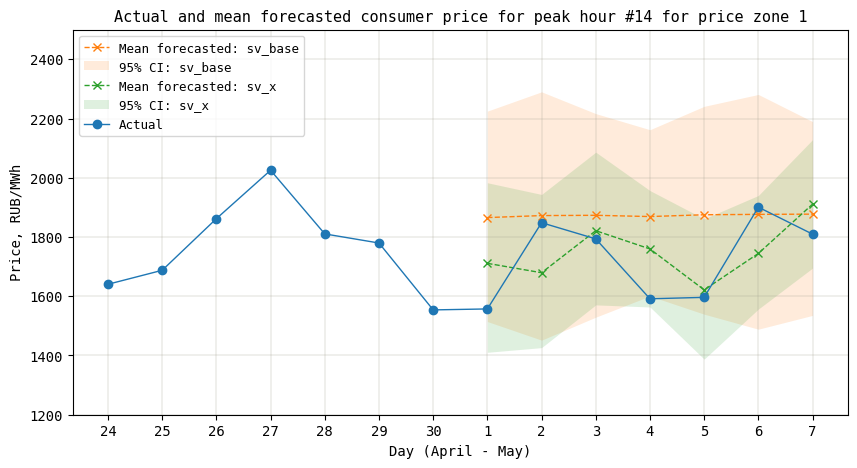

In [144]:
plt.figure(figsize=(10, 5))
for i, forecast, model in zip([1, 2], [forecast_sv_base_peak_eur_many, forecast_sv_x_peak_eur_many], [model_sv_base_peak_eur, model_sv_x_peak_eur]):
    plt.plot(price_temp_data_peak_eur.loc['2024-05-01':]['CONSUMER_PRICE'].index, forecast.mean(axis=1), color=f'C{i}', marker='x', lw=1, ls='--', label=f'Mean forecasted: {model.kind}')
    plt.fill_between(price_temp_data_peak_eur.loc['2024-05-01':]['CONSUMER_PRICE'].index, np.percentile(forecast, 2.5, axis=1), np.percentile(forecast, 97.5, axis=1), color=f'C{i}', lw=0, alpha=0.15, label=f'95% CI: {model.kind}')
plt.plot(price_temp_data_peak_eur.loc['2024-04-24':]['CONSUMER_PRICE'].index, price_temp_data_peak_eur.loc['2024-04-24':]['CONSUMER_PRICE'], marker='o', color='C0', lw=1, label='Actual')
plt.xlabel('Day (April - May)', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(price_temp_data_peak_eur.loc['2024-04-24':]['CONSUMER_PRICE'].index, price_temp_data_peak_eur.loc['2024-04-24':]['CONSUMER_PRICE'].index.day, size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1200, 2500])
plt.title(f'Actual and mean forecasted consumer price for peak hour #{hour_max_eur} for price zone 1', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

In [145]:
%%capture
# Peak hour + Price zone 2
forecast_sv_base_peak_sib_many = model_sv_base_peak_sib.forecast_many(X=price_temp_data_peak_sib['CONSUMER_PRICE'], y=price_temp_data_peak_sib['CONSUMER_PRICE'], num_days=7)

In [146]:
%%capture
forecast_sv_x_peak_sib_many = model_sv_x_peak_sib.forecast_many(X=price_temp_data_peak_sib[['Temperature', 'Weekday']], y=price_temp_data_peak_sib['CONSUMER_PRICE'], num_days=7)

In [147]:
pd.DataFrame({'sv_base': [
    mean_absolute_error(price_temp_data_peak_sib.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_base_peak_sib_many.mean(axis=1)), 
    root_mean_squared_error(price_temp_data_peak_sib.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_base_peak_sib_many.mean(axis=1))],
    'sv_x': [mean_absolute_error(price_temp_data_peak_sib.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_x_peak_sib_many.mean(axis=1)),
    root_mean_squared_error(price_temp_data_peak_sib.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_x_peak_sib_many.mean(axis=1))]},
    index=['mae', 'rmse']).style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Peak hour + Price zone 2</h4>')

,sv_base,sv_x
mae,316.212214,98.259862
rmse,341.776689,109.512284


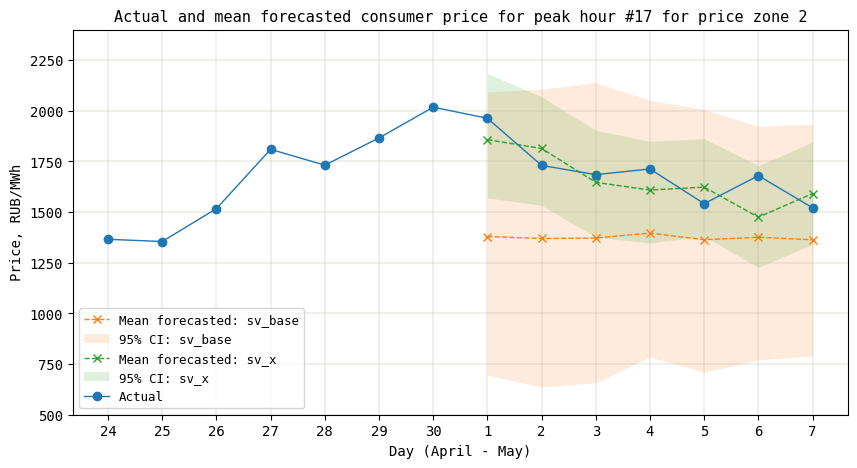

In [148]:
plt.figure(figsize=(10, 5))
for i, forecast, model in zip([1, 2], [forecast_sv_base_peak_sib_many, forecast_sv_x_peak_sib_many], [model_sv_base_peak_sib, model_sv_x_peak_sib]):
    plt.plot(price_temp_data_peak_sib.loc['2024-05-01':]['CONSUMER_PRICE'].index, forecast.mean(axis=1), color=f'C{i}', marker='x', lw=1, ls='--', label=f'Mean forecasted: {model.kind}')
    plt.fill_between(price_temp_data_peak_sib.loc['2024-05-01':]['CONSUMER_PRICE'].index, np.percentile(forecast, 2.5, axis=1), np.percentile(forecast, 97.5, axis=1), color=f'C{i}', lw=0, alpha=0.15, label=f'95% CI: {model.kind}')
plt.plot(price_temp_data_peak_sib.loc['2024-04-24':]['CONSUMER_PRICE'].index, price_temp_data_peak_sib.loc['2024-04-24':]['CONSUMER_PRICE'], color='C0', marker='o', lw=1, label='Actual')
plt.xlabel('Day (April - May)', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(price_temp_data_peak_sib.loc['2024-04-24':]['CONSUMER_PRICE'].index, price_temp_data_peak_sib.loc['2024-04-24':]['CONSUMER_PRICE'].index.day, size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([500, 2400])
plt.title(f'Actual and mean forecasted consumer price for peak hour #{hour_max_sib} for price zone 2', size=11, family='monospace')
plt.legend(loc='lower left', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

In [149]:
%%capture
# Off-peak hour + Price zone 1
forecast_sv_base_offpeak_eur_many = model_sv_base_offpeak_eur.forecast_many(X=price_temp_data_offpeak_eur['CONSUMER_PRICE'], y=price_temp_data_offpeak_eur['CONSUMER_PRICE'], num_days=7)

In [150]:
%%capture
forecast_sv_x_offpeak_eur_many = model_sv_x_offpeak_eur.forecast_many(X=price_temp_data_offpeak_eur[['Temperature', 'Weekday']], y=price_temp_data_offpeak_eur['CONSUMER_PRICE'], num_days=7)

In [151]:
pd.DataFrame({'sv_base': [
    mean_absolute_error(price_temp_data_offpeak_eur.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_base_offpeak_eur_many.mean(axis=1)), 
    root_mean_squared_error(price_temp_data_offpeak_eur.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_base_offpeak_eur_many.mean(axis=1))],
    'sv_x': [mean_absolute_error(price_temp_data_offpeak_eur.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_x_offpeak_eur_many.mean(axis=1)),
    root_mean_squared_error(price_temp_data_offpeak_eur.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_x_offpeak_eur_many.mean(axis=1))]},
    index=['mae', 'rmse']).style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Off-peak hour + Price zone 1</h4>')

,sv_base,sv_x
mae,82.740057,90.979826
rmse,90.217905,116.537310


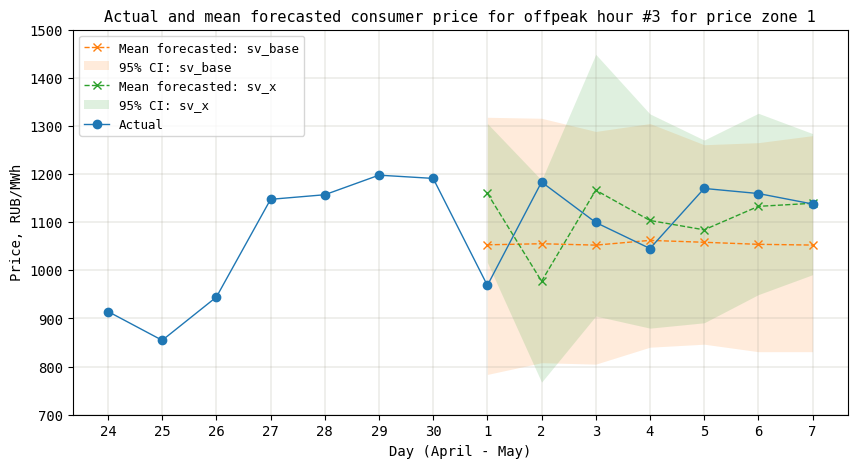

In [152]:
plt.figure(figsize=(10, 5))
for i, forecast, model in zip([1, 2], [forecast_sv_base_offpeak_eur_many, forecast_sv_x_offpeak_eur_many], [model_sv_base_offpeak_eur, model_sv_x_offpeak_eur]):
    plt.plot(price_temp_data_offpeak_eur.loc['2024-05-01':]['CONSUMER_PRICE'].index, forecast.mean(axis=1), color=f'C{i}', marker='x', lw=1, ls='--', label=f'Mean forecasted: {model.kind}')
    plt.fill_between(price_temp_data_offpeak_eur.loc['2024-05-01':]['CONSUMER_PRICE'].index, np.percentile(forecast, 2.5, axis=1), np.percentile(forecast, 97.5, axis=1), color=f'C{i}', lw=0, alpha=0.15, label=f'95% CI: {model.kind}')
plt.plot(price_temp_data_offpeak_eur.loc['2024-04-24':]['CONSUMER_PRICE'].index, price_temp_data_offpeak_eur.loc['2024-04-24':]['CONSUMER_PRICE'], color='C0', marker='o', lw=1, label='Actual')
plt.xlabel('Day (April - May)', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(price_temp_data_offpeak_eur.loc['2024-04-24':]['CONSUMER_PRICE'].index, price_temp_data_offpeak_eur.loc['2024-04-24':]['CONSUMER_PRICE'].index.day, size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([700, 1500])
plt.title(f'Actual and mean forecasted consumer price for offpeak hour #{hour_min_eur} for price zone 1', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

In [153]:
%%capture
# Off-peak hour + Price zone 2
forecast_sv_base_offpeak_sib_many = model_sv_base_offpeak_sib.forecast_many(X=price_temp_data_offpeak_sib['CONSUMER_PRICE'], y=price_temp_data_offpeak_sib['CONSUMER_PRICE'], num_days=7)

In [154]:
%%capture
forecast_sv_x_offpeak_sib_many = model_sv_x_offpeak_sib.forecast_many(X=price_temp_data_offpeak_sib[['Temperature', 'Weekday']], y=price_temp_data_offpeak_sib['CONSUMER_PRICE'], num_days=7)

In [155]:
pd.DataFrame({'sv_base': [
    mean_absolute_error(price_temp_data_offpeak_sib.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_base_offpeak_sib_many.mean(axis=1)), 
    root_mean_squared_error(price_temp_data_offpeak_sib.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_base_offpeak_sib_many.mean(axis=1))],
    'sv_x': [mean_absolute_error(price_temp_data_offpeak_sib.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_x_offpeak_sib_many.mean(axis=1)),
    root_mean_squared_error(price_temp_data_offpeak_sib.loc['2024-05-01':]['CONSUMER_PRICE'], forecast_sv_x_offpeak_sib_many.mean(axis=1))]},
    index=['mae', 'rmse']).style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Off-peak hour + Price zone 2</h4>')

,sv_base,sv_x
mae,267.636644,75.344225
rmse,284.460232,106.692888


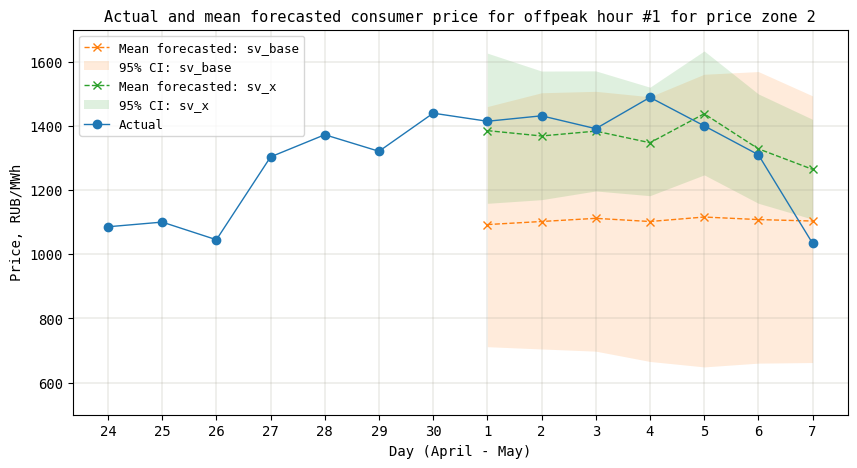

In [156]:
plt.figure(figsize=(10, 5))
for i, forecast, model in zip([1, 2], [forecast_sv_base_offpeak_sib_many, forecast_sv_x_offpeak_sib_many], [model_sv_base_offpeak_sib, model_sv_x_offpeak_sib]):
    plt.plot(price_temp_data_offpeak_sib.loc['2024-05-01':]['CONSUMER_PRICE'].index, forecast.mean(axis=1), color=f'C{i}', marker='x', lw=1, ls='--', label=f'Mean forecasted: {model.kind}')
    plt.fill_between(price_temp_data_offpeak_sib.loc['2024-05-01':]['CONSUMER_PRICE'].index, np.percentile(forecast, 2.5, axis=1), np.percentile(forecast, 97.5, axis=1), color=f'C{i}', lw=0, alpha=0.15, label=f'95% CI: {model.kind}')
plt.plot(price_temp_data_offpeak_sib.loc['2024-04-24':]['CONSUMER_PRICE'].index, price_temp_data_offpeak_sib.loc['2024-04-24':]['CONSUMER_PRICE'], color='C0', marker='o', lw=1, label='Actual')
plt.xlabel('Day (April - May)', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(price_temp_data_offpeak_sib.loc['2024-04-24':]['CONSUMER_PRICE'].index, price_temp_data_offpeak_sib.loc['2024-04-24':]['CONSUMER_PRICE'].index.day, size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([500, 1700])
plt.title(f'Actual and mean forecasted consumer price for offpeak hour #{hour_min_sib} for price zone 2', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

**Overall, both models' 95% CI of all sampled forecasts cover the actual price. SV X model provides a narrower forecast CI as compared to SV Baseline model.**

[Back](#toc)

---
##### <a id="refs"></a>6. References

1) [Administrator of Trading System (ATS), Daily Indices and Volumes of The Day-ahead Market](https://www.atsenergo.ru/results/rsv/index)
2) [Raspisaniye Pogodi Ltd., Reliable Prognosis](https://rp5.ru/)
3) [Kim Sangjoon, Neil Shephard, and Siddhartha Chib. Stochastic Volatility: Likelihood Inference and Comparison with ARCH Models. Review of Economic Studies (65), 1998](https://apps.olin.wustl.edu/faculty/chib/papers/KimShephardChib98.pdf)
4) [Maciej Kostrzewski, Jadwiga Kostrzewska. Probabilistic electricity price forecasting with Bayesian stochastic volatility models. Energy Economics (80), 2019](https://www.sciencedirect.com/science/article/abs/pii/S0140988319300544)
5) [Stan User's Guide. Time-Series Models](https://mc-stan.org/docs/stan-users-guide/time-series.html)
6) [Michael Clark. Bayesian Stochastic Volatility Model](https://m-clark.github.io/models-by-example/bayesian-stochastic-volatility.html)
7) [Prashant Banerjee. Complete Guide on Time Series Analysis in Python](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)
8) [scikit-learn User's Guide](https://scikit-learn.org/stable/user_guide.html)
9) [statsmodels User's Guide](https://www.statsmodels.org/stable/user-guide.html)
10) [SciPy documentation](https://docs.scipy.org/doc/scipy/)
11) [NumPy documentation](https://numpy.org/doc/stable/index.html)
12) [pandas documentation](https://pandas.pydata.org/docs/)
13) [Matplotlib User's Guide](https://matplotlib.org/stable/users/index)
14) [seaborn User’s Guide](https://seaborn.pydata.org/tutorial.html)
15) [Python](https://www.python.org/about/)
16) [Jupyter Notebook](https://jupyter-notebook.readthedocs.io/en/latest/notebook.html)

[Back](#toc)